In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

import ligo.skymap.plot

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "times new roman" 
# plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

data_dir = 'data'

## load data

In [2]:
# Reading all these files need about 3 mins
cigale_fagn0 = ascii.read(os.path.join(data_dir, 'cigale_fagn0.dat'), format='basic', guess=False, fast_reader={'chunk_size': 100*1000000})
cigale_float = ascii.read(os.path.join(data_dir, 'cigale_float.dat'), format='basic', guess=False, fast_reader={'chunk_size': 100*1000000})
src_table = ascii.read(os.path.join(data_dir, 'src_table.dat'), format='basic', guess=False, fast_reader={'chunk_size': 100*1000000})
len(src_table)

3262183

In [3]:
ra = src_table['RA']
dec = src_table['DEC']
cigale_coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

VLA: https://iopscience.iop.org/article/10.1088/0004-6256/142/1/3

In [4]:
Hodge11 = ascii.read(os.path.join(data_dir, 'stripe82_2010may25.cat'), format='no_header', data_start=2, delimiter=' ', 
                      names=['h', 'm', 's', 'deg', 'min', 'sec', 'P(S)', 'Fpeak', 'Fint', 'RMS', 'Maj', 'Min', 'PA', 
                             'fMaj', 'fMin', 'fPA', 'Field', '#', 'Sep', 'i', 'Cl'])
Hodge11['RA'] = Hodge11['h']*u.h + Hodge11['m']*u.min + Hodge11['s']*u.s
Hodge11['Dec'] = Hodge11['deg']*u.deg + Hodge11['min']*u.arcmin + Hodge11['sec']*u.arcsec
len(Hodge11)

17969

3977

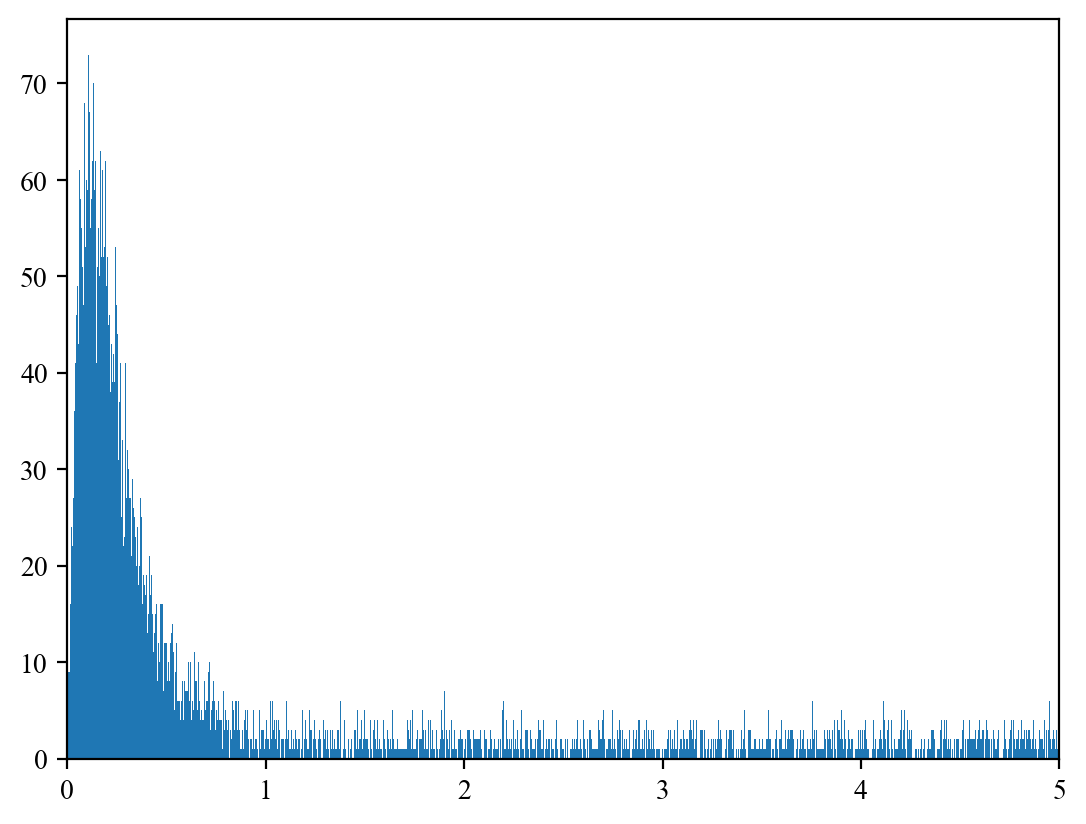

In [5]:
Hodge11_coord = SkyCoord(ra=Hodge11['RA'], dec=Hodge11['Dec'])

idx, d2d, d3d = cigale_coord.match_to_catalog_3d(Hodge11_coord)

max_sep = 1*u.arcsec
Hodge11_sel = d2d<max_sep

plt.hist(d2d.arcsec[d2d.arcsec<5], bins=1000)
plt.xlim(0, 5)

np.count_nonzero(Hodge11_sel)

X-Ray + WISE AGNs: https://iopscience.iop.org/article/10.1088/0004-6256/142/1/3

In [6]:
Lamassa19 = Table.read(os.path.join(data_dir, 's82x_eboss_catalog_submitted.fits'))
len(Lamassa19)

4847

(3320, 1952, 1351, 10)

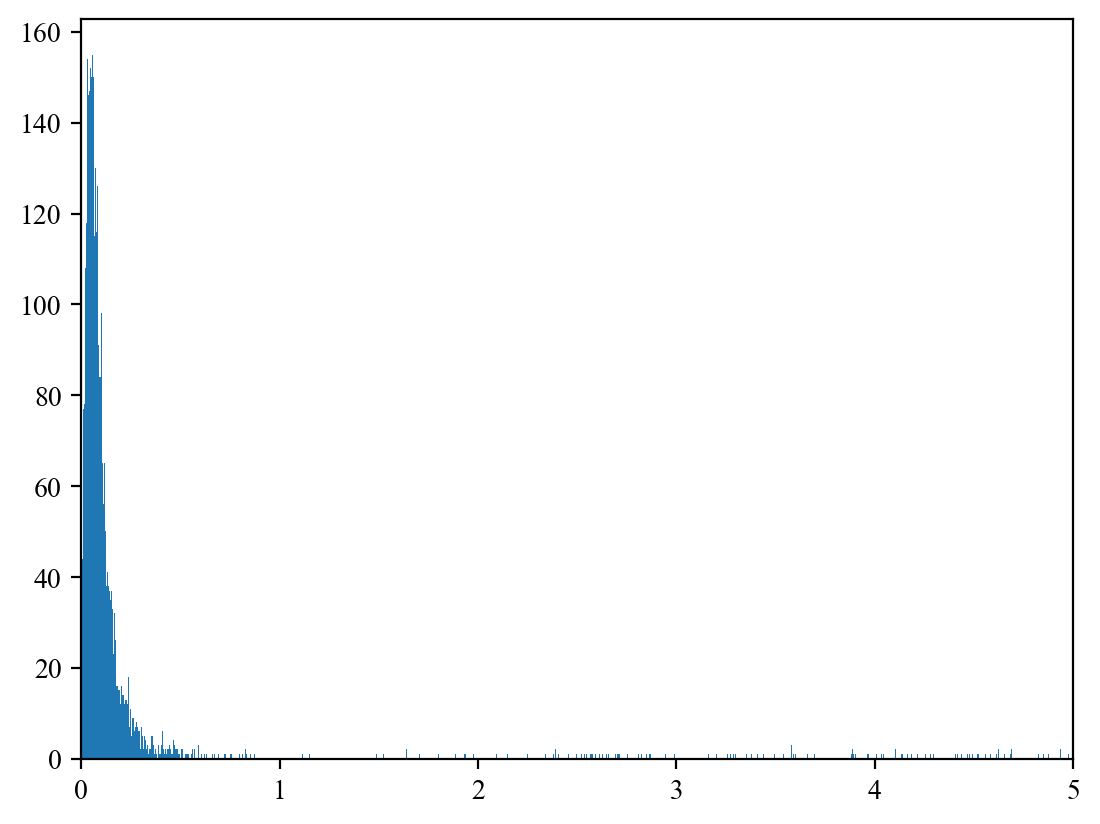

In [7]:
Lamassa19_coord = SkyCoord(ra=Lamassa19['SDSS_RA']*u.deg, dec=Lamassa19['SDSS_Dec']*u.deg)

idx, d2d, d3d = cigale_coord.match_to_catalog_3d(Lamassa19_coord)

max_sep = 1*u.arcsec
Lamassa19_sel = d2d<max_sep

Lamassa19QSO_sel = (Lamassa19_sel) & (Lamassa19[idx]['class']=='QSO')
Lamassa19Gal_sel = (Lamassa19_sel) & (Lamassa19[idx]['class']=='GALAXY')
Lamassa19Star_sel = (Lamassa19_sel) & (Lamassa19[idx]['class']=='STAR')

plt.hist(d2d.arcsec[d2d.arcsec<5], bins=1000)
plt.xlim(0, 5)

np.count_nonzero(Lamassa19_sel), np.count_nonzero(Lamassa19QSO_sel), np.count_nonzero(Lamassa19Gal_sel), np.count_nonzero(Lamassa19Star_sel)

WISE AGN catalog: https://iopscience.iop.org/article/10.3847/1538-4365/aaa00a

In [8]:
Aseef18R90 = Table.read(os.path.join(data_dir, 'table1.bin.fits'))
Aseef18C75 = Table.read(os.path.join(data_dir, 'table2.bin.fits'))
len(Aseef18R90), len(Aseef18C75)

(4543530, 20907127)

(35511,)

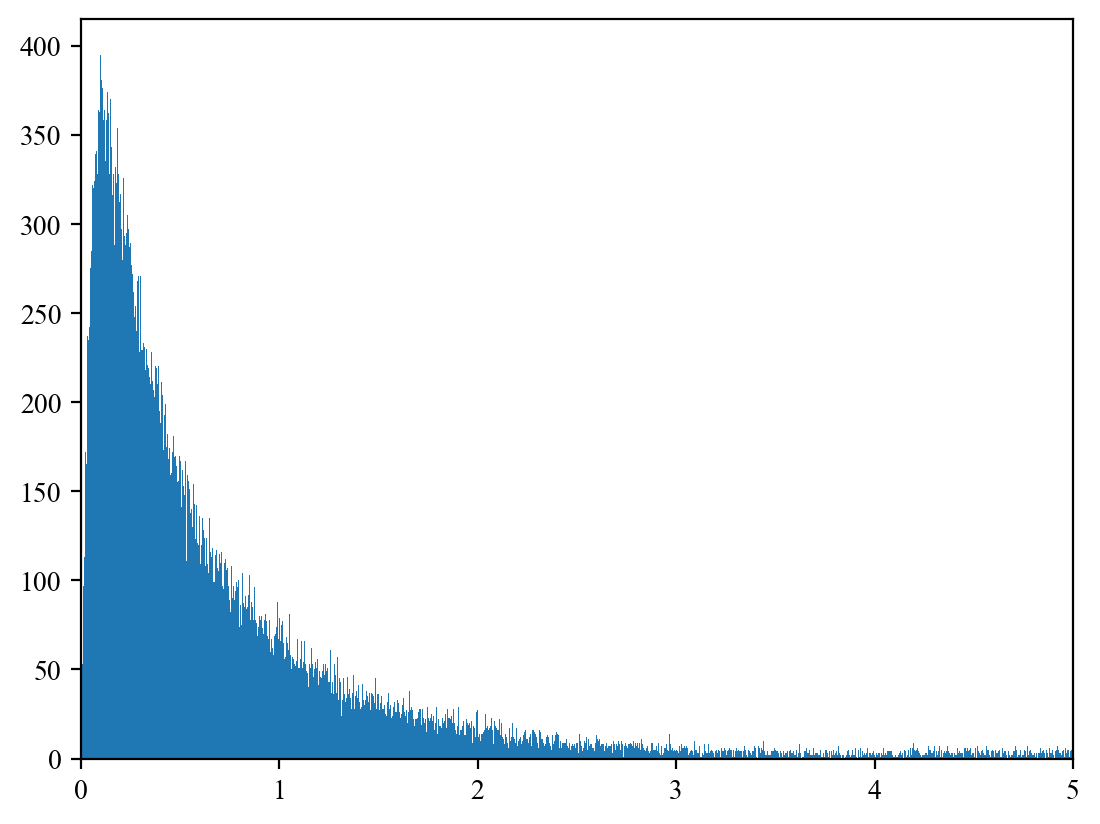

In [9]:
Aseef18R90_coord = SkyCoord(ra=Aseef18R90['RA'], dec=Aseef18R90['Dec'])

idx, d2d, d3d = cigale_coord.match_to_catalog_3d(Aseef18R90_coord)

max_sep = 1*u.arcsec
Aseef18R90_sel = d2d<max_sep

plt.hist(d2d.arcsec[d2d.arcsec<5], bins=1000)
plt.xlim(0, 5)

np.count_nonzero(Aseef18R90_sel), 

## Source profile

Package used to plot: 

In [53]:
from ligo.skymap.plot.allsky import Astro, Degrees, Globe, WCSInsetConnectionPatch, WCSCircleInsetConnectionPatch, AutoScaledWCSAxes
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from matplotlib.projections import register_projection
from astropy.coordinates import SkyCoord, UnitSphericalRepresentation
from astropy.visualization.wcsaxes import SphericalCircle, WCSAxes

class AstroDegreesClip(AutoScaledWCSAxes): 
    
    name = 'astro degrees clip'
    
    '''Astro'''
    _crval1 = 180
    _xcoord = 'RA--'
    _ycoord = 'DEC-'
    _radesys = 'ICRS'

    def __init__(self, *args, center='0d 0d', width = '1 deg', height='1 deg', rotate=None,
                 **kwargs):
        
        '''Clip'''
        center = SkyCoord(
            center, representation_type=UnitSphericalRepresentation).icrs
        width = u.Quantity(width).to(u.deg).value
        height = u.Quantity(height).to(u.deg).value
        header = {
            'NAXIS': 2,
            'NAXIS1': 512*width,
            'NAXIS2': 512*height,
            'CRPIX1': 256.5*width,
            'CRPIX2': 256.5*height,
            'CRVAL1': center.ra.deg,
            'CRVAL2': center.dec.deg,
            'CDELT1': -0.003, # -width / 1024,
            'CDELT2': 0.003, # height / 1024,
            'CTYPE1': self._xcoord + '-MOL', # '-SIN',
            'CTYPE2': self._ycoord + '-MOL', # '-SIN',
            'RADESYS': self._radesys}
        if rotate is not None:
            header['LONPOLE'] = u.Quantity(rotate).to_value(u.deg)
        super().__init__(*args, header=header, **kwargs) # frame_class=EllipticalFrame
        
        '''Degrees'''
        self.coords[0].set_format_unit(u.degree)

register_projection(AstroDegreesClip)

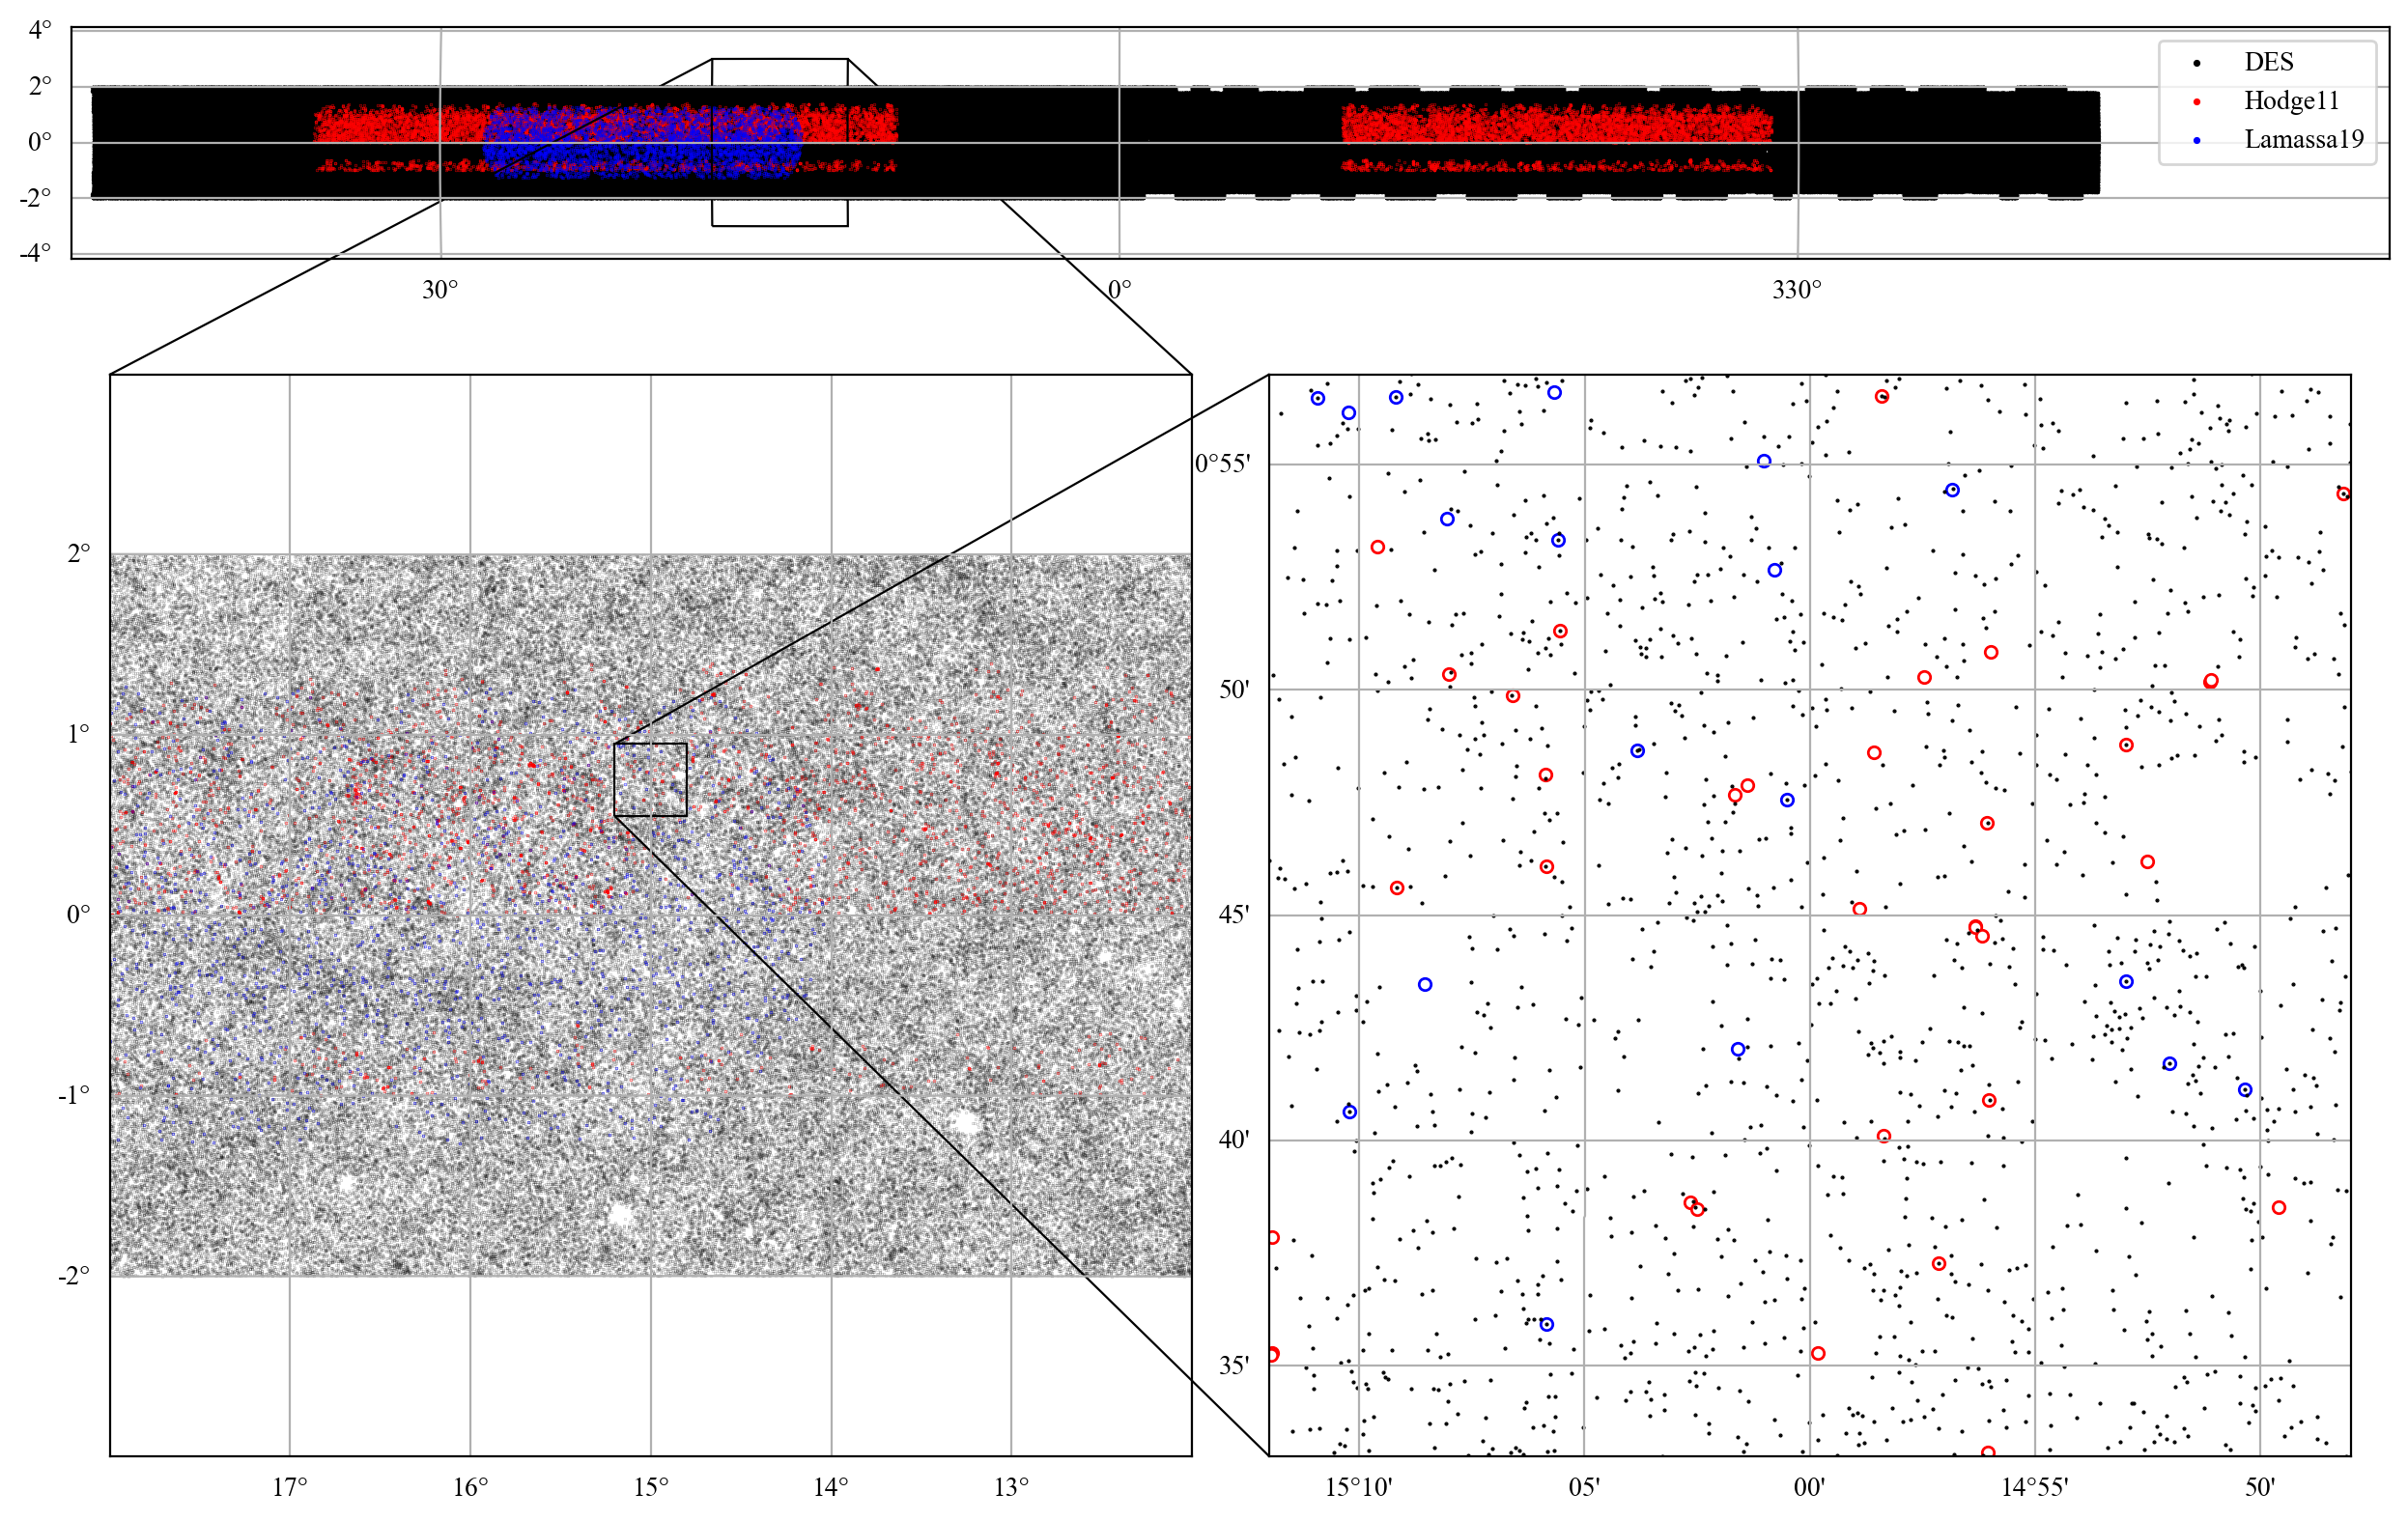

In [86]:
fig = plt.figure(figsize=[12, 8], dpi=100)
ax1 = plt.axes([0, 0.7, 1, 0.3], projection='astro degrees clip', center='355d 0d', width = '60 deg', height='6 deg')
ax2 = plt.axes([-0.1, 0, 0.7, 0.7], projection='astro degrees zoom', center='15d 0d', radius='3 deg')
ax3 = plt.axes([0.4, 0, 0.7, 0.7], projection='astro degrees zoom', center='15d 0d45m', radius='0.2 deg')

ax1.scatter(ra,                  dec,                    s=0.1,    marker='.', label='DES',        color='k', transform=ax1.get_transform('world'))
ax1.scatter(Hodge11_coord.ra,    Hodge11_coord.dec,      s=0.1,     marker='.', label='Hodge11',        color='r', transform=ax1.get_transform('world'))
ax1.scatter(Lamassa19_coord.ra,  Lamassa19_coord.dec,    s=0.1,      marker='.', label='Lamassa19',      color='b', transform=ax1.get_transform('world'))

ax2.scatter(ra,                   dec,                    s=0.01, marker='.', label='DES',        color='k', transform=ax2.get_transform('world'))
ax2.scatter(Hodge11_coord.ra,     Hodge11_coord.dec,      s=0.1,  marker='.', label='Hodge11',        color='r', transform=ax2.get_transform('world'))
ax2.scatter(Lamassa19_coord.ra,   Lamassa19_coord.dec,    s=0.1,  marker='.', label='Lamassa19',      color='b', transform=ax2.get_transform('world'))

ax3.scatter(Lamassa19_coord.ra,    Lamassa19_coord.dec,    s=20,   marker='o', c='w',  edgecolors='b', label='Lamassa19',  transform=ax3.get_transform('world'))
ax3.scatter(Hodge11_coord.ra,      Hodge11_coord.dec,      s=20,   marker='o', c='w',  edgecolors='r', label='Hodge11',    transform=ax3.get_transform('world'))
ax3.scatter(ra,                    dec,                    s=1,    marker='.', color='k',              label='DES',    transform=ax3.get_transform('world'))

ax1.grid()
ax1.legend(markerscale=10, loc='upper right')
ax1.coords['ra'].set_ticks_visible(False)
ax1.coords['dec'].set_ticks_visible(False)
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)
ax1.mark_inset_axes(ax2)
ax1.connect_inset_axes(ax2, 'upper left')
ax1.connect_inset_axes(ax2, 'upper right')
ax2.grid()
ax2.coords['ra'].set_ticks_visible(False)
ax2.coords['dec'].set_ticks_visible(False)
ax2.coords['ra'].set_auto_axislabel(False)
ax2.coords['dec'].set_auto_axislabel(False)
ax2.mark_inset_axes(ax3)
ax2.connect_inset_axes(ax3, 'upper left')
ax2.connect_inset_axes(ax3, 'lower left')
ax3.grid()
ax3.coords['ra'].set_ticks_visible(False)
ax3.coords['dec'].set_ticks_visible(False)
ax3.coords['ra'].set_auto_axislabel(False)
ax3.coords['dec'].set_auto_axislabel(False)

plt.show()

## Plot Chi2

In [12]:
float_chi2 = cigale_float['best.reduced_chi_square']
fagn0_chi2 = cigale_fagn0['best.reduced_chi_square']
redshift = src_table['redshift']

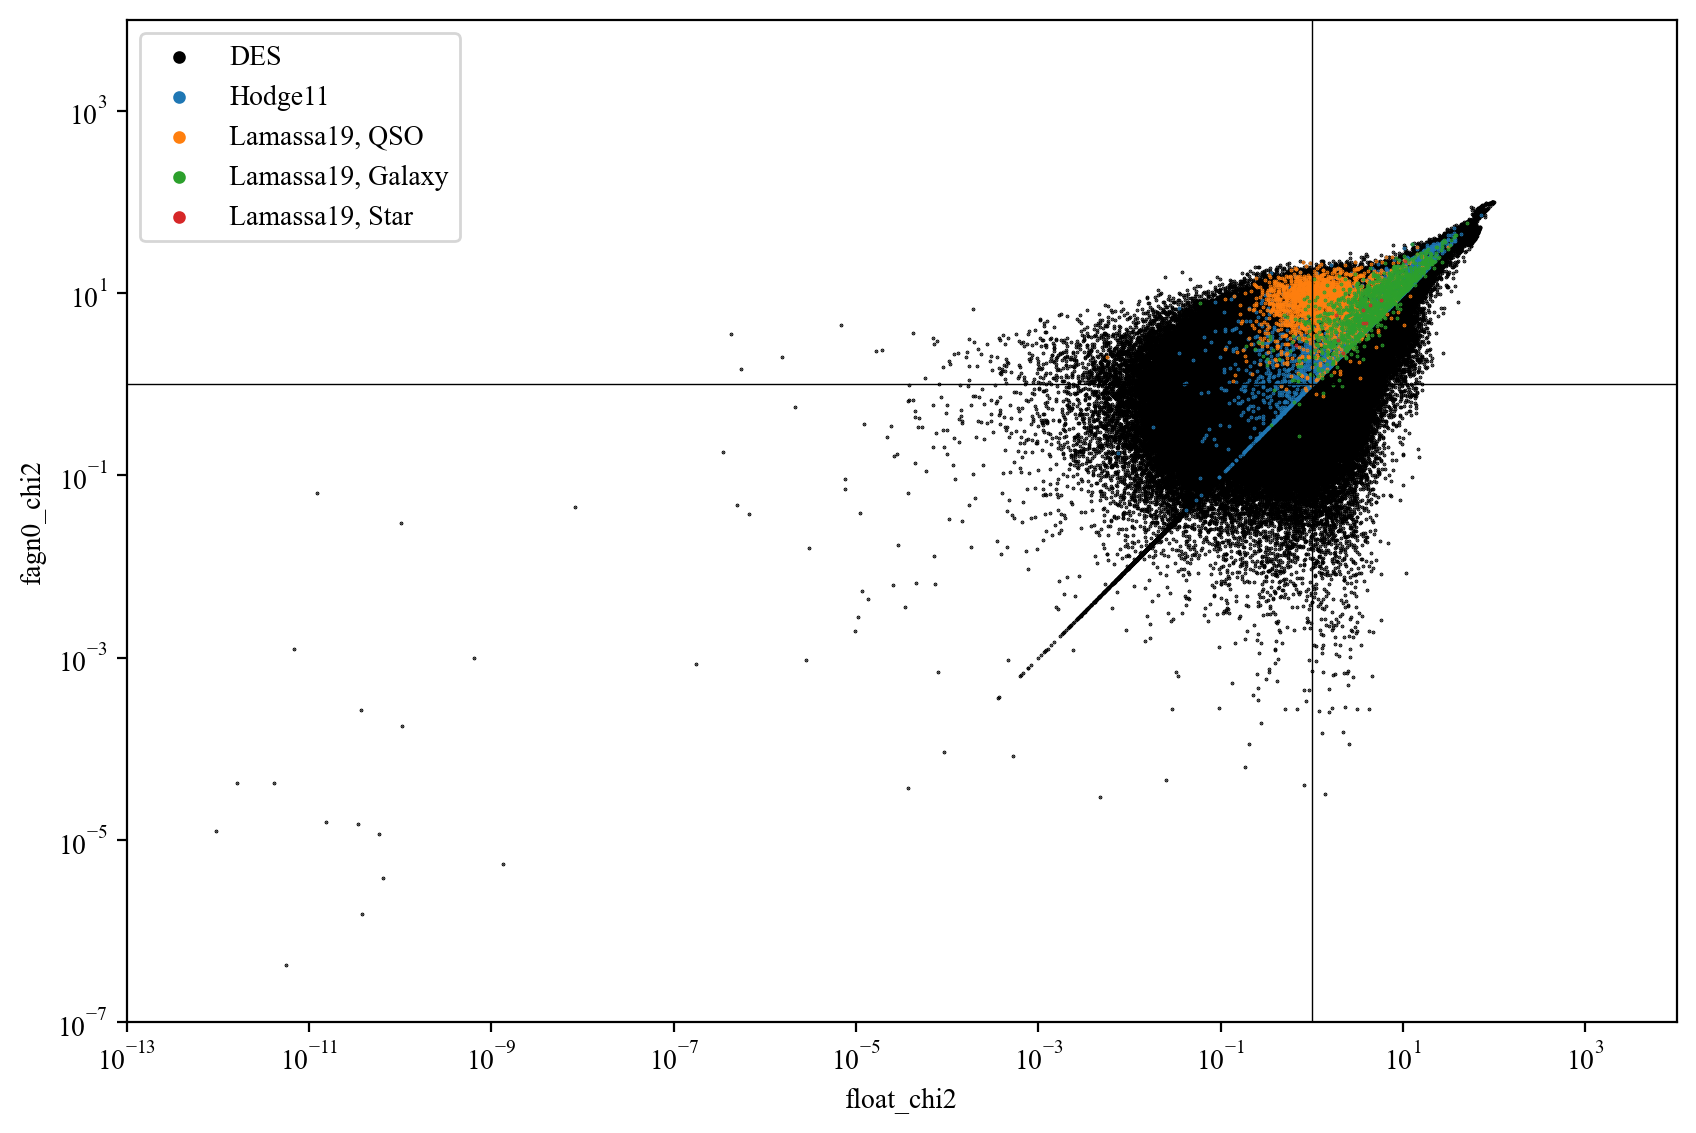

In [13]:
fig, ax1 = plt.subplots(figsize=[10, 10])

plt.scatter(float_chi2,                     fagn0_chi2,                     marker='.', s=0.5,  label='DES', color='k')
plt.scatter(float_chi2[Hodge11_sel],        fagn0_chi2[Hodge11_sel],        marker='.', s=0.5,  label='Hodge11')
plt.scatter(float_chi2[Lamassa19QSO_sel],   fagn0_chi2[Lamassa19QSO_sel],   marker='.', s=0.5,  label='Lamassa19, QSO')
plt.scatter(float_chi2[Lamassa19Gal_sel],   fagn0_chi2[Lamassa19Gal_sel],   marker='.', s=0.5,  label='Lamassa19, Galaxy')
plt.scatter(float_chi2[Lamassa19Star_sel],  fagn0_chi2[Lamassa19Star_sel],  marker='.', s=0.5,  label='Lamassa19, Star')

plt.xlim(1e-13, 1e4)
plt.ylim(1e-7, 1e4)
ax1.set_aspect(1)
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.xlabel('float_chi2')
plt.ylabel('fagn0_chi2')
# plt.axline((0, 0), slope=1, color='k', linewidth=0.5)
plt.hlines(xmin=0, xmax=1e4, y=1, color='k', linewidth=0.5)
plt.vlines(ymin=0, ymax=1e4, x=1, color='k', linewidth=0.5)
plt.legend(loc='upper left', markerscale=10)

plt.show()

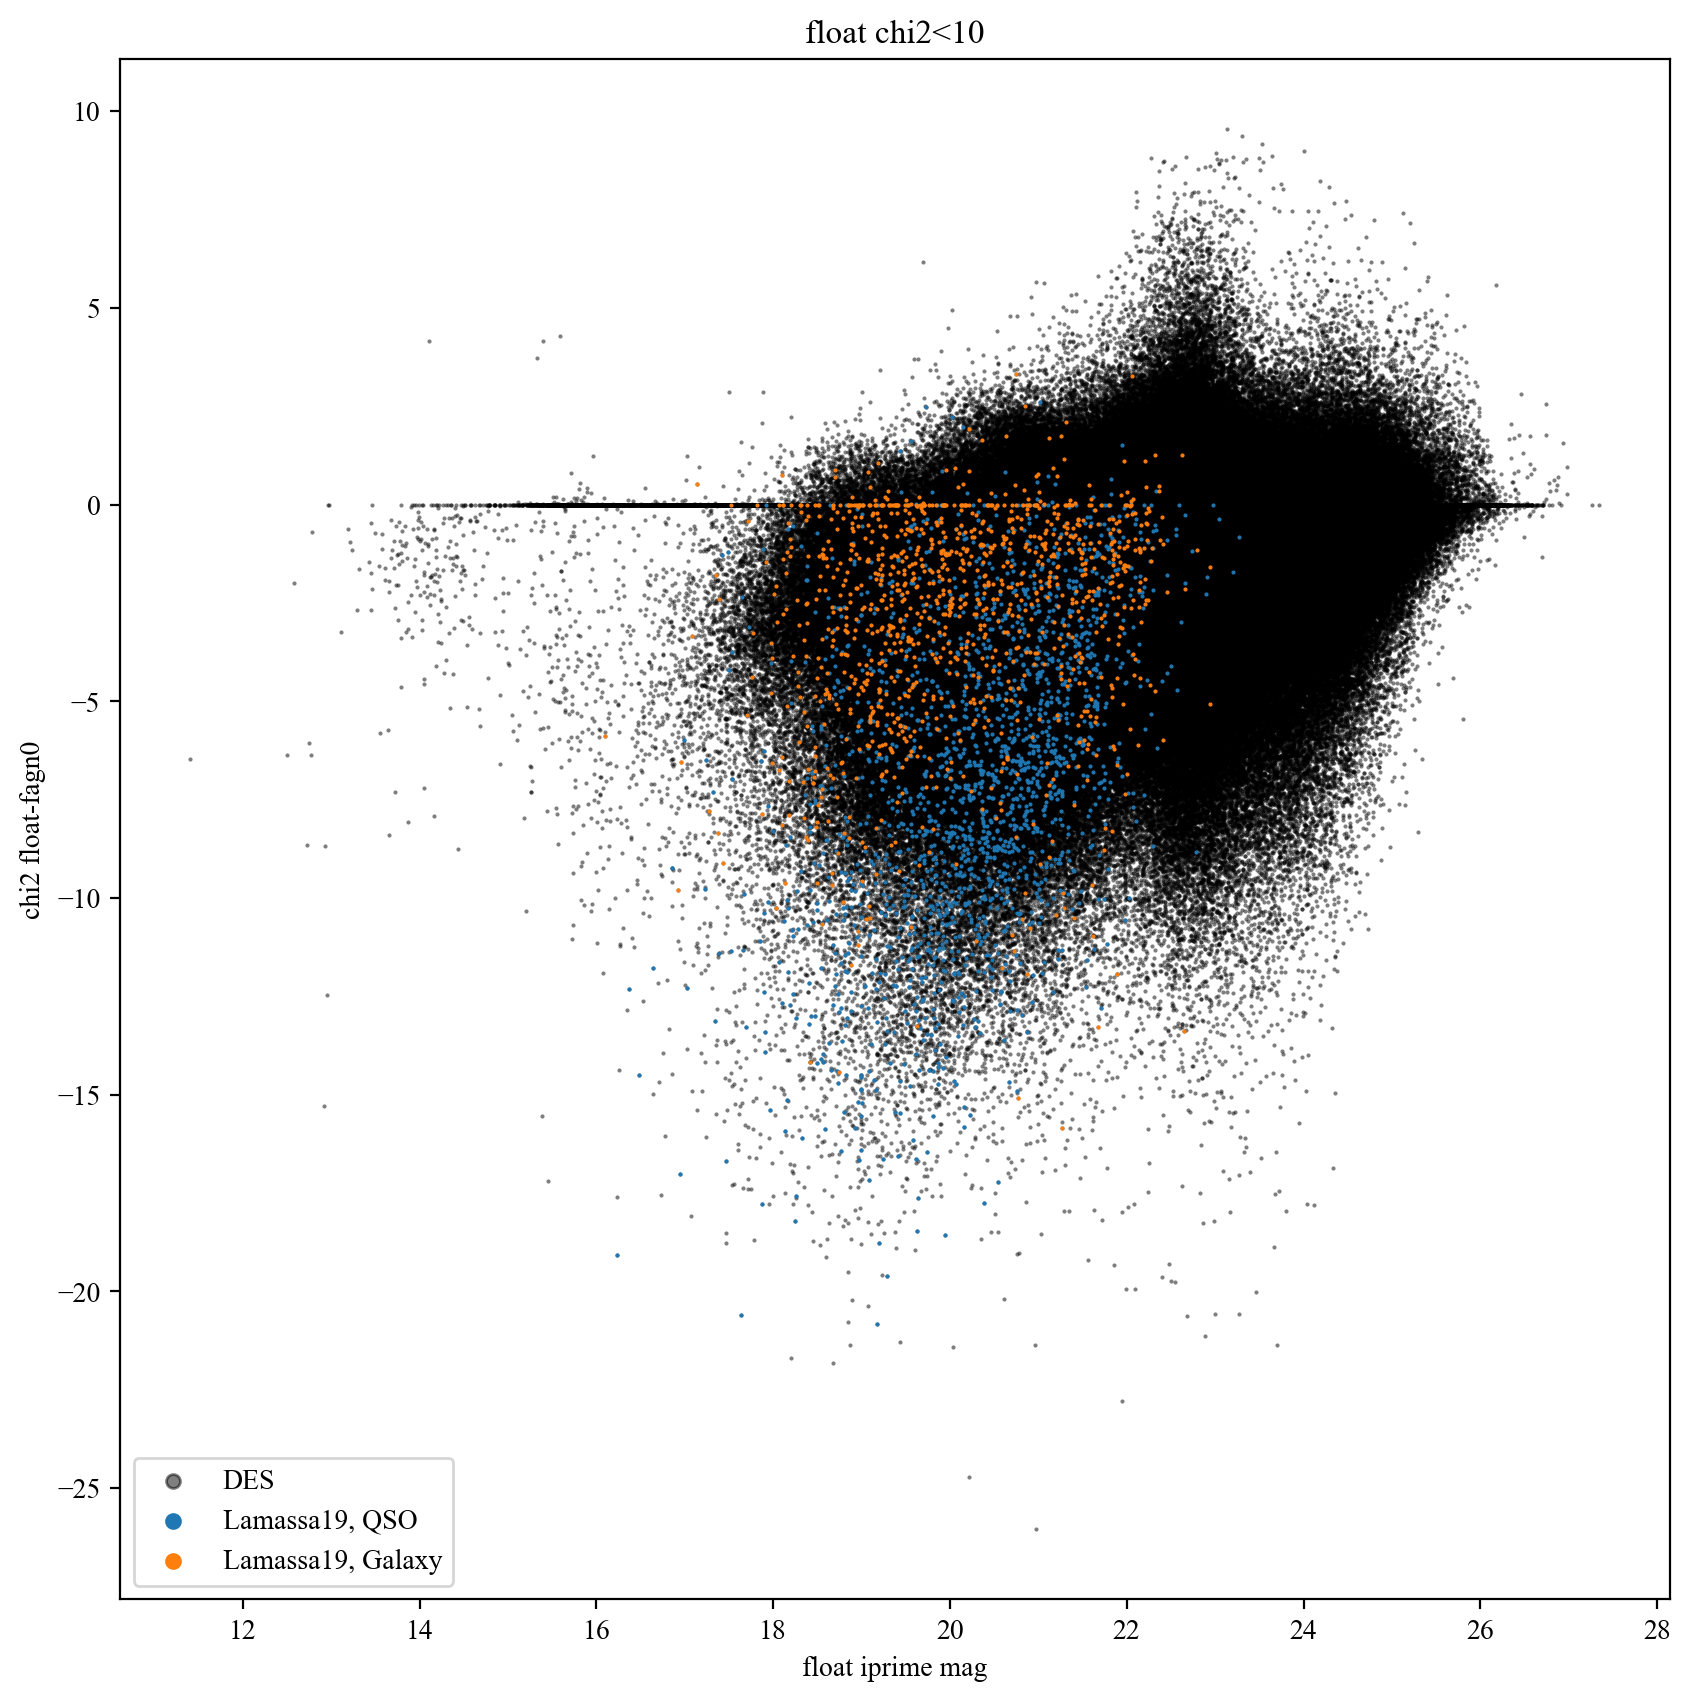

In [14]:

zero_point_star_equiv = u.zero_point_flux(3631.1 * u.Jy)

fagn0_i = cigale_fagn0['best.i_prime']*u.mJy
float_i = cigale_float['best.i_prime']*u.mJy
fagn0_m = u.Magnitude(fagn0_i.to(u.AB, equivalencies=zero_point_star_equiv)) 
float_m = u.Magnitude(float_i.to(u.AB, equivalencies=zero_point_star_equiv)) 

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10, 10], sharex=True)
# fig.subplots_adjust(hspace=0, wspace=0)
# ax1.get_shared_x_axes().join(ax1, ax2)

# ax1.scatter(fagn0_m, fagn0_chi2, marker='.', s=1, alpha=0.5, label='fagn0')
# ax1.scatter(float_m, float_chi2, marker='.', s=1, alpha=0.5, label='float')
# ax1.set_ylim(1, 100)
# ax1.legend(loc='upper left', markerscale=10)

# ax2.scatter(fagn0_m, fagn0_chi2, marker='.', s=1, alpha=0.5, label='fagn0')
# ax2.scatter(float_m, float_chi2, marker='.', s=1, alpha=0.5, label='float')
# ax2.set_ylim(0, 1)
# ax2.set_xlabel('iprime mag')
# ax2.set_ylabel('chi2')

fig, ax1 = plt.subplots(figsize=[10, 10])

# ax1.scatter(fagn0_m, fagn0_chi2, marker='.', s=1, alpha=0.5, label='fagn0')
# ax1.scatter(float_m, float_chi2, marker='.', s=1, alpha=0.5, label='float')
im = ax1.scatter(float_m[float_chi2<10], (float_chi2-fagn0_chi2)[float_chi2<10], marker='.', c='k', s=1, alpha=0.5, label='DES')
# im = ax1.scatter(float_m, (float_chi2-fagn0_chi2), marker='.', s=1, alpha=0.5, label='DES')
plt.scatter(float_m[(float_chi2<10) & Lamassa19QSO_sel],   (float_chi2-fagn0_chi2)[(float_chi2<10) & Lamassa19QSO_sel],   marker='.', s=1,  label='Lamassa19, QSO')
plt.scatter(float_m[(float_chi2<10) & Lamassa19Gal_sel],   (float_chi2-fagn0_chi2)[(float_chi2<10) & Lamassa19Gal_sel],   marker='.', s=1,  label='Lamassa19, Galaxy')

# ax1.hlines(xmin=8, xmax=35, y=1, color='k', linewidth=0.5)
# ax1.set_ylim(1e-13, 100)
# ax1.set_xlim(8, 35)
# ax1.set_yscale('log')
ax1.legend(loc='lower left', markerscale=10)
ax1.set_xlabel('float iprime mag')
ax1.set_ylabel('chi2 float-fagn0')
ax1.set_title('float chi2<10')
# fig.colorbar(im, ax1=ax1).set_label('fagn0')

plt.show()

IndexError: index 256824 is out of bounds for axis 0 with size 4847

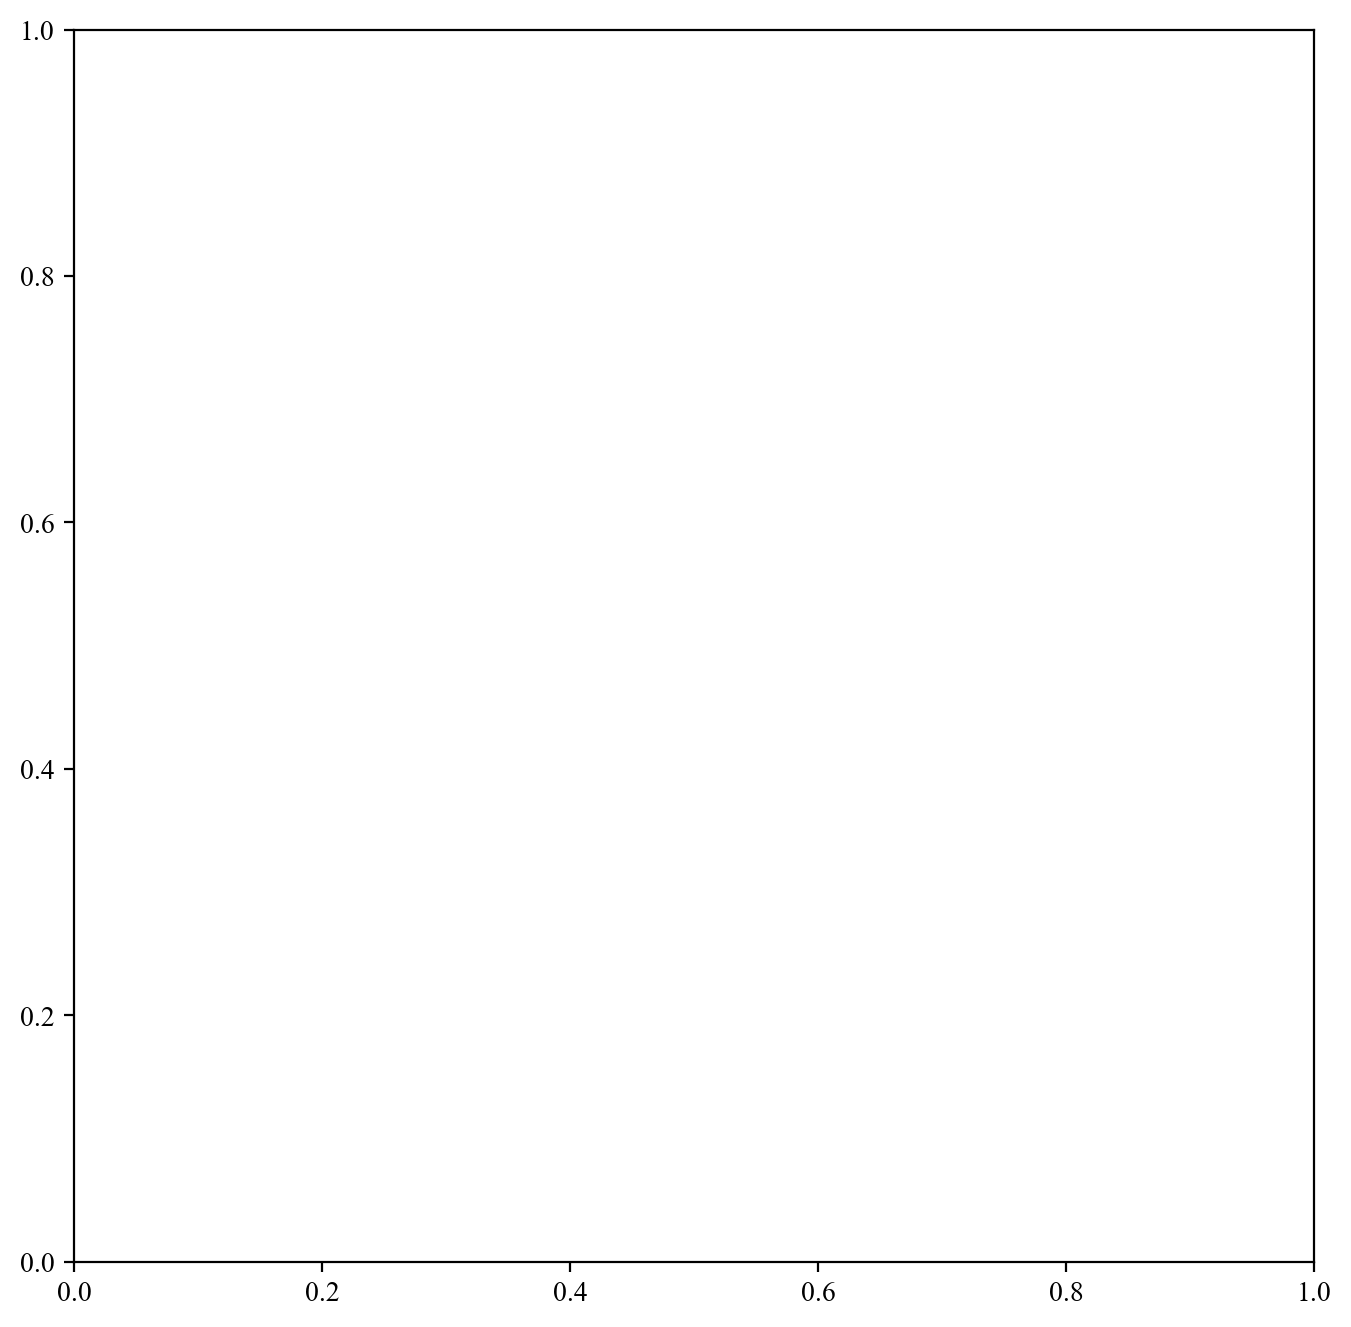

In [15]:
from scipy.stats import gaussian_kde

fig, ax1 = plt.subplots(figsize=[8, 8])

plt.hist2d(Lamassa19[idx[Lamassa19_sel]]['redshift'], redshift[Lamassa19_sel], bins=[150, 100])
plt.xlim(None, 2)

# data = np.vstack([Lamassa19[idx[Lamassa19_sel]]['redshift'], redshift[Lamassa19_sel]])
# kde = gaussian_kde(data, bw_method=0.05)
# X, Y = np.meshgrid(np.linspace(0, 2, 1000), np.linspace(0, 2, 1000))
# Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
# plt.imshow(Z.reshape(X.shape), origin='lower', extent=[0, 2, 0, 2])
# ax1.set_aspect(1)

plt.axline((0, 0), slope=1, color='k', linewidth=0.5)
plt.colorbar(fraction=0.05, pad=0.05)

plt.show()

---

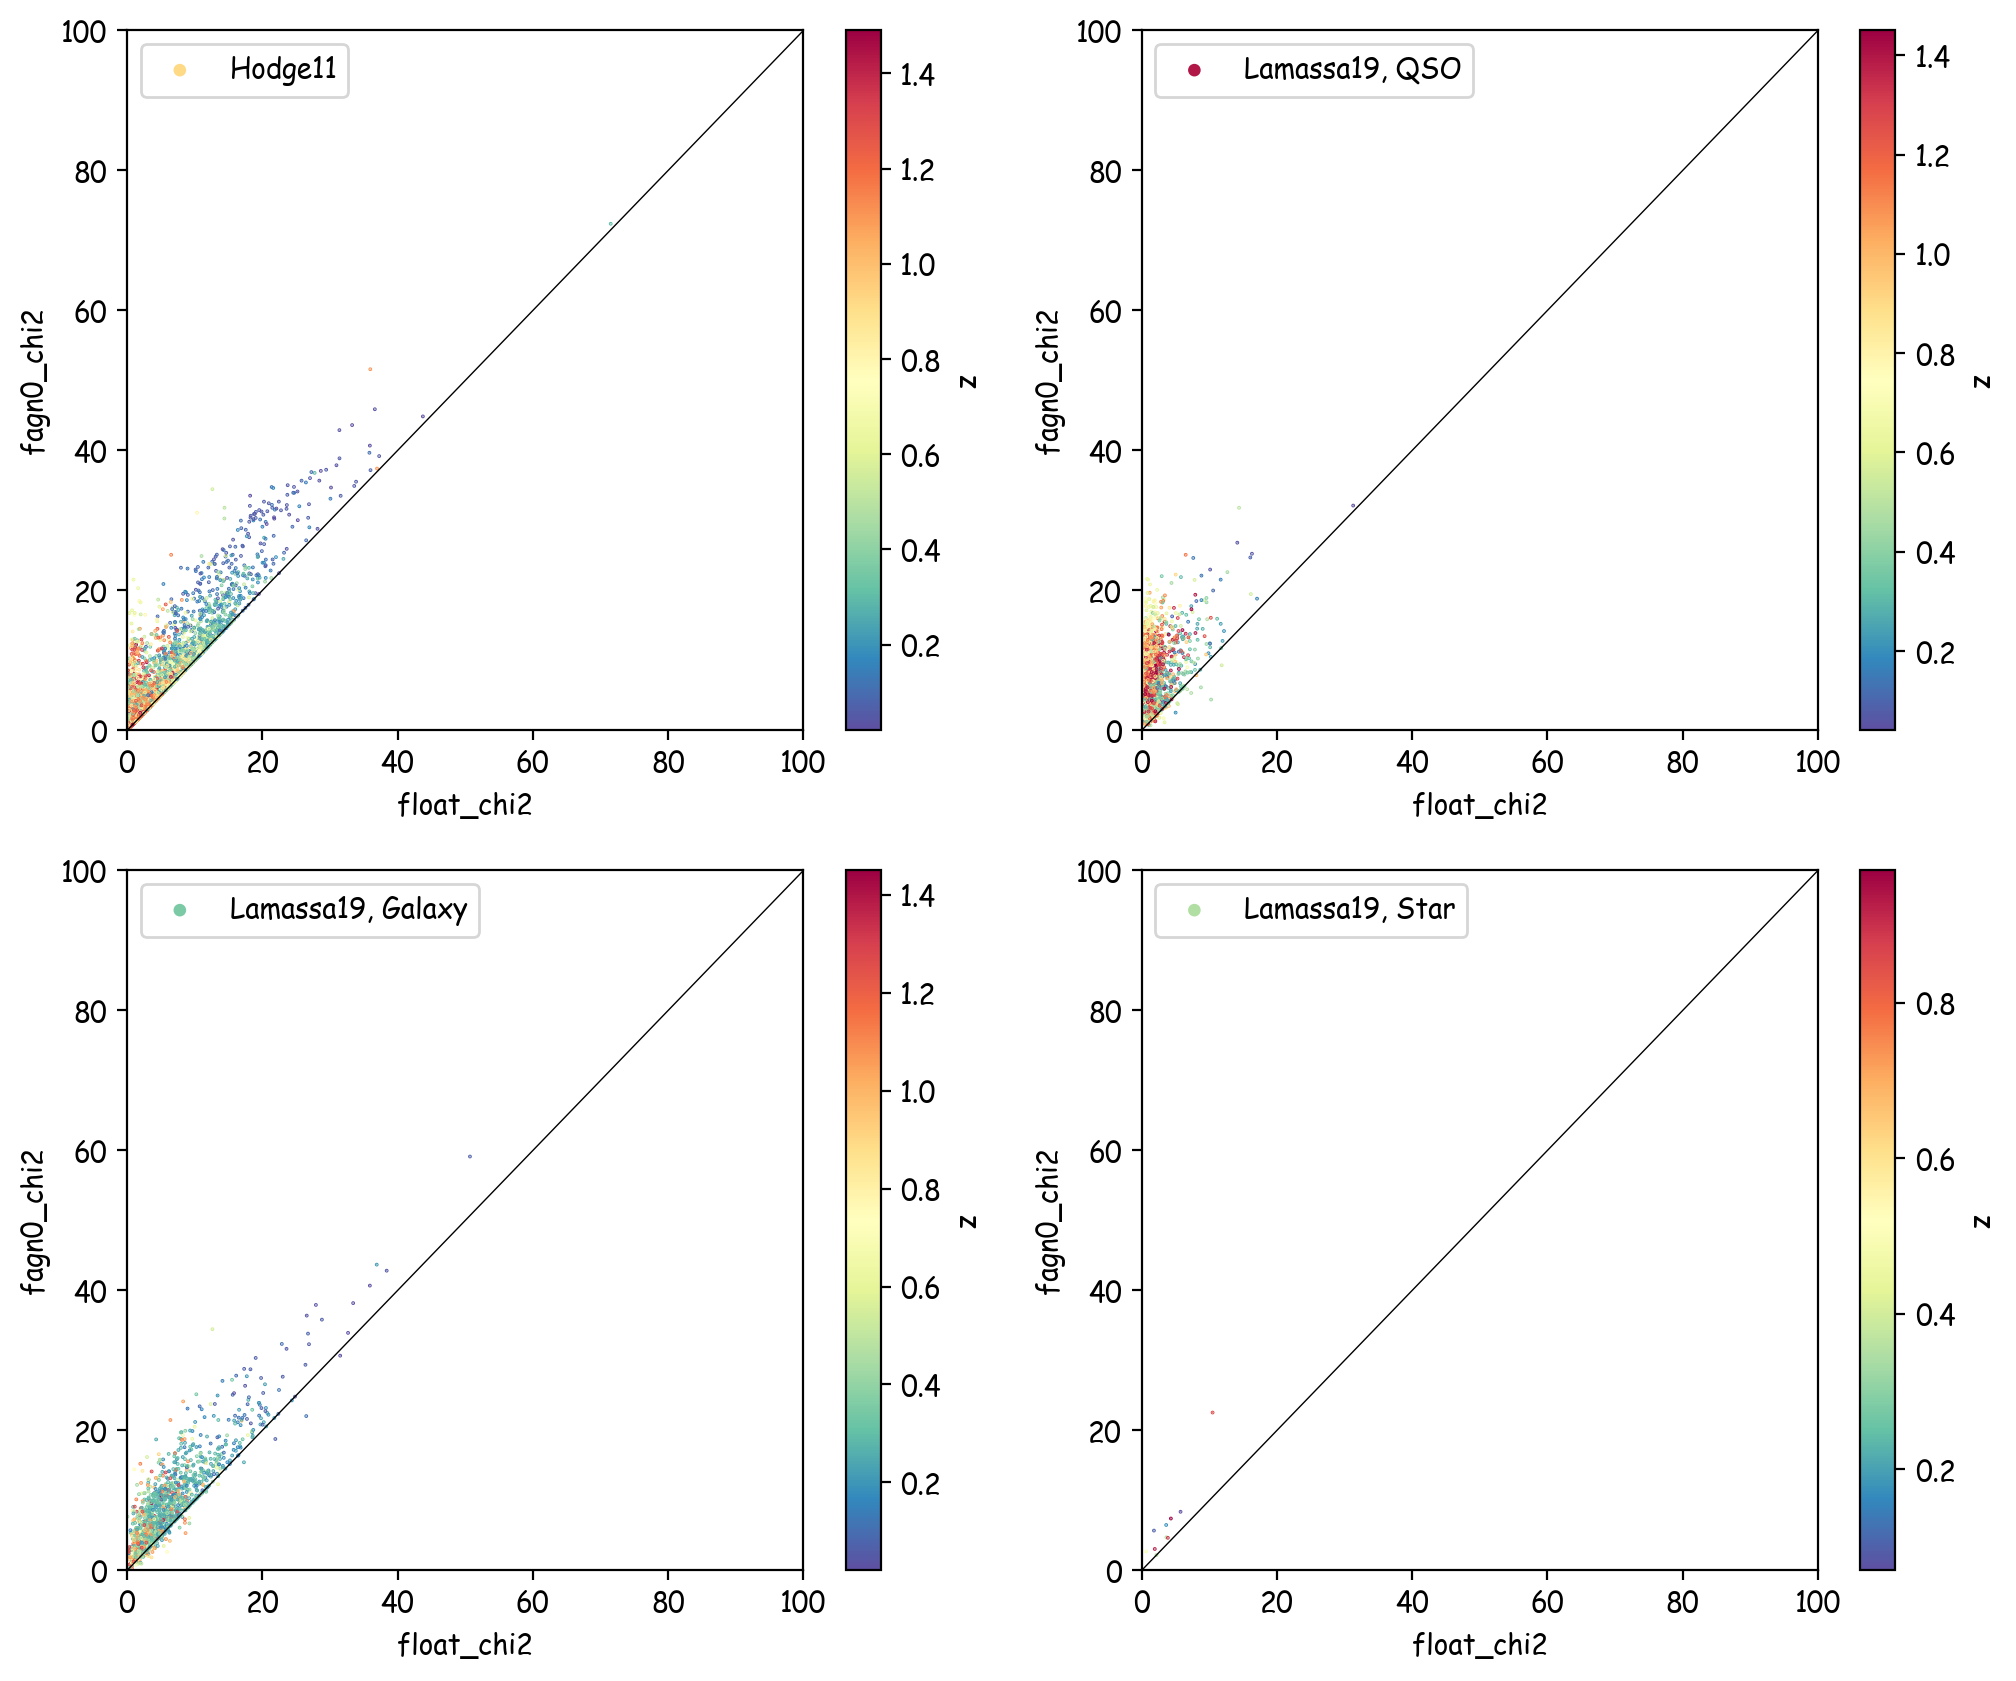

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=[12, 10])

for ax1, sel, label in zip(axs.reshape(4), [Hodge11_sel, Lamassa19QSO_sel, Lamassa19Gal_sel, Lamassa19Star_sel], \
                          ['Hodge11', 'Lamassa19, QSO', 'Lamassa19, Galaxy', 'Lamassa19, Star']): 
    im = ax1.scatter(float_chi2[sel], fagn0_chi2[sel], marker='.', s=0.5,  label=label, c=redshift[sel], cmap='Spectral_r')
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, 100)
    ax1.set_xlabel('float_chi2')
    ax1.set_ylabel('fagn0_chi2')
    ax1.axline((0, 0), slope=1, color='k', linewidth=0.5)
    ax1.legend(loc='upper left', markerscale=10)
    cb = plt.colorbar(im)
    cb.set_label('z')

plt.show()

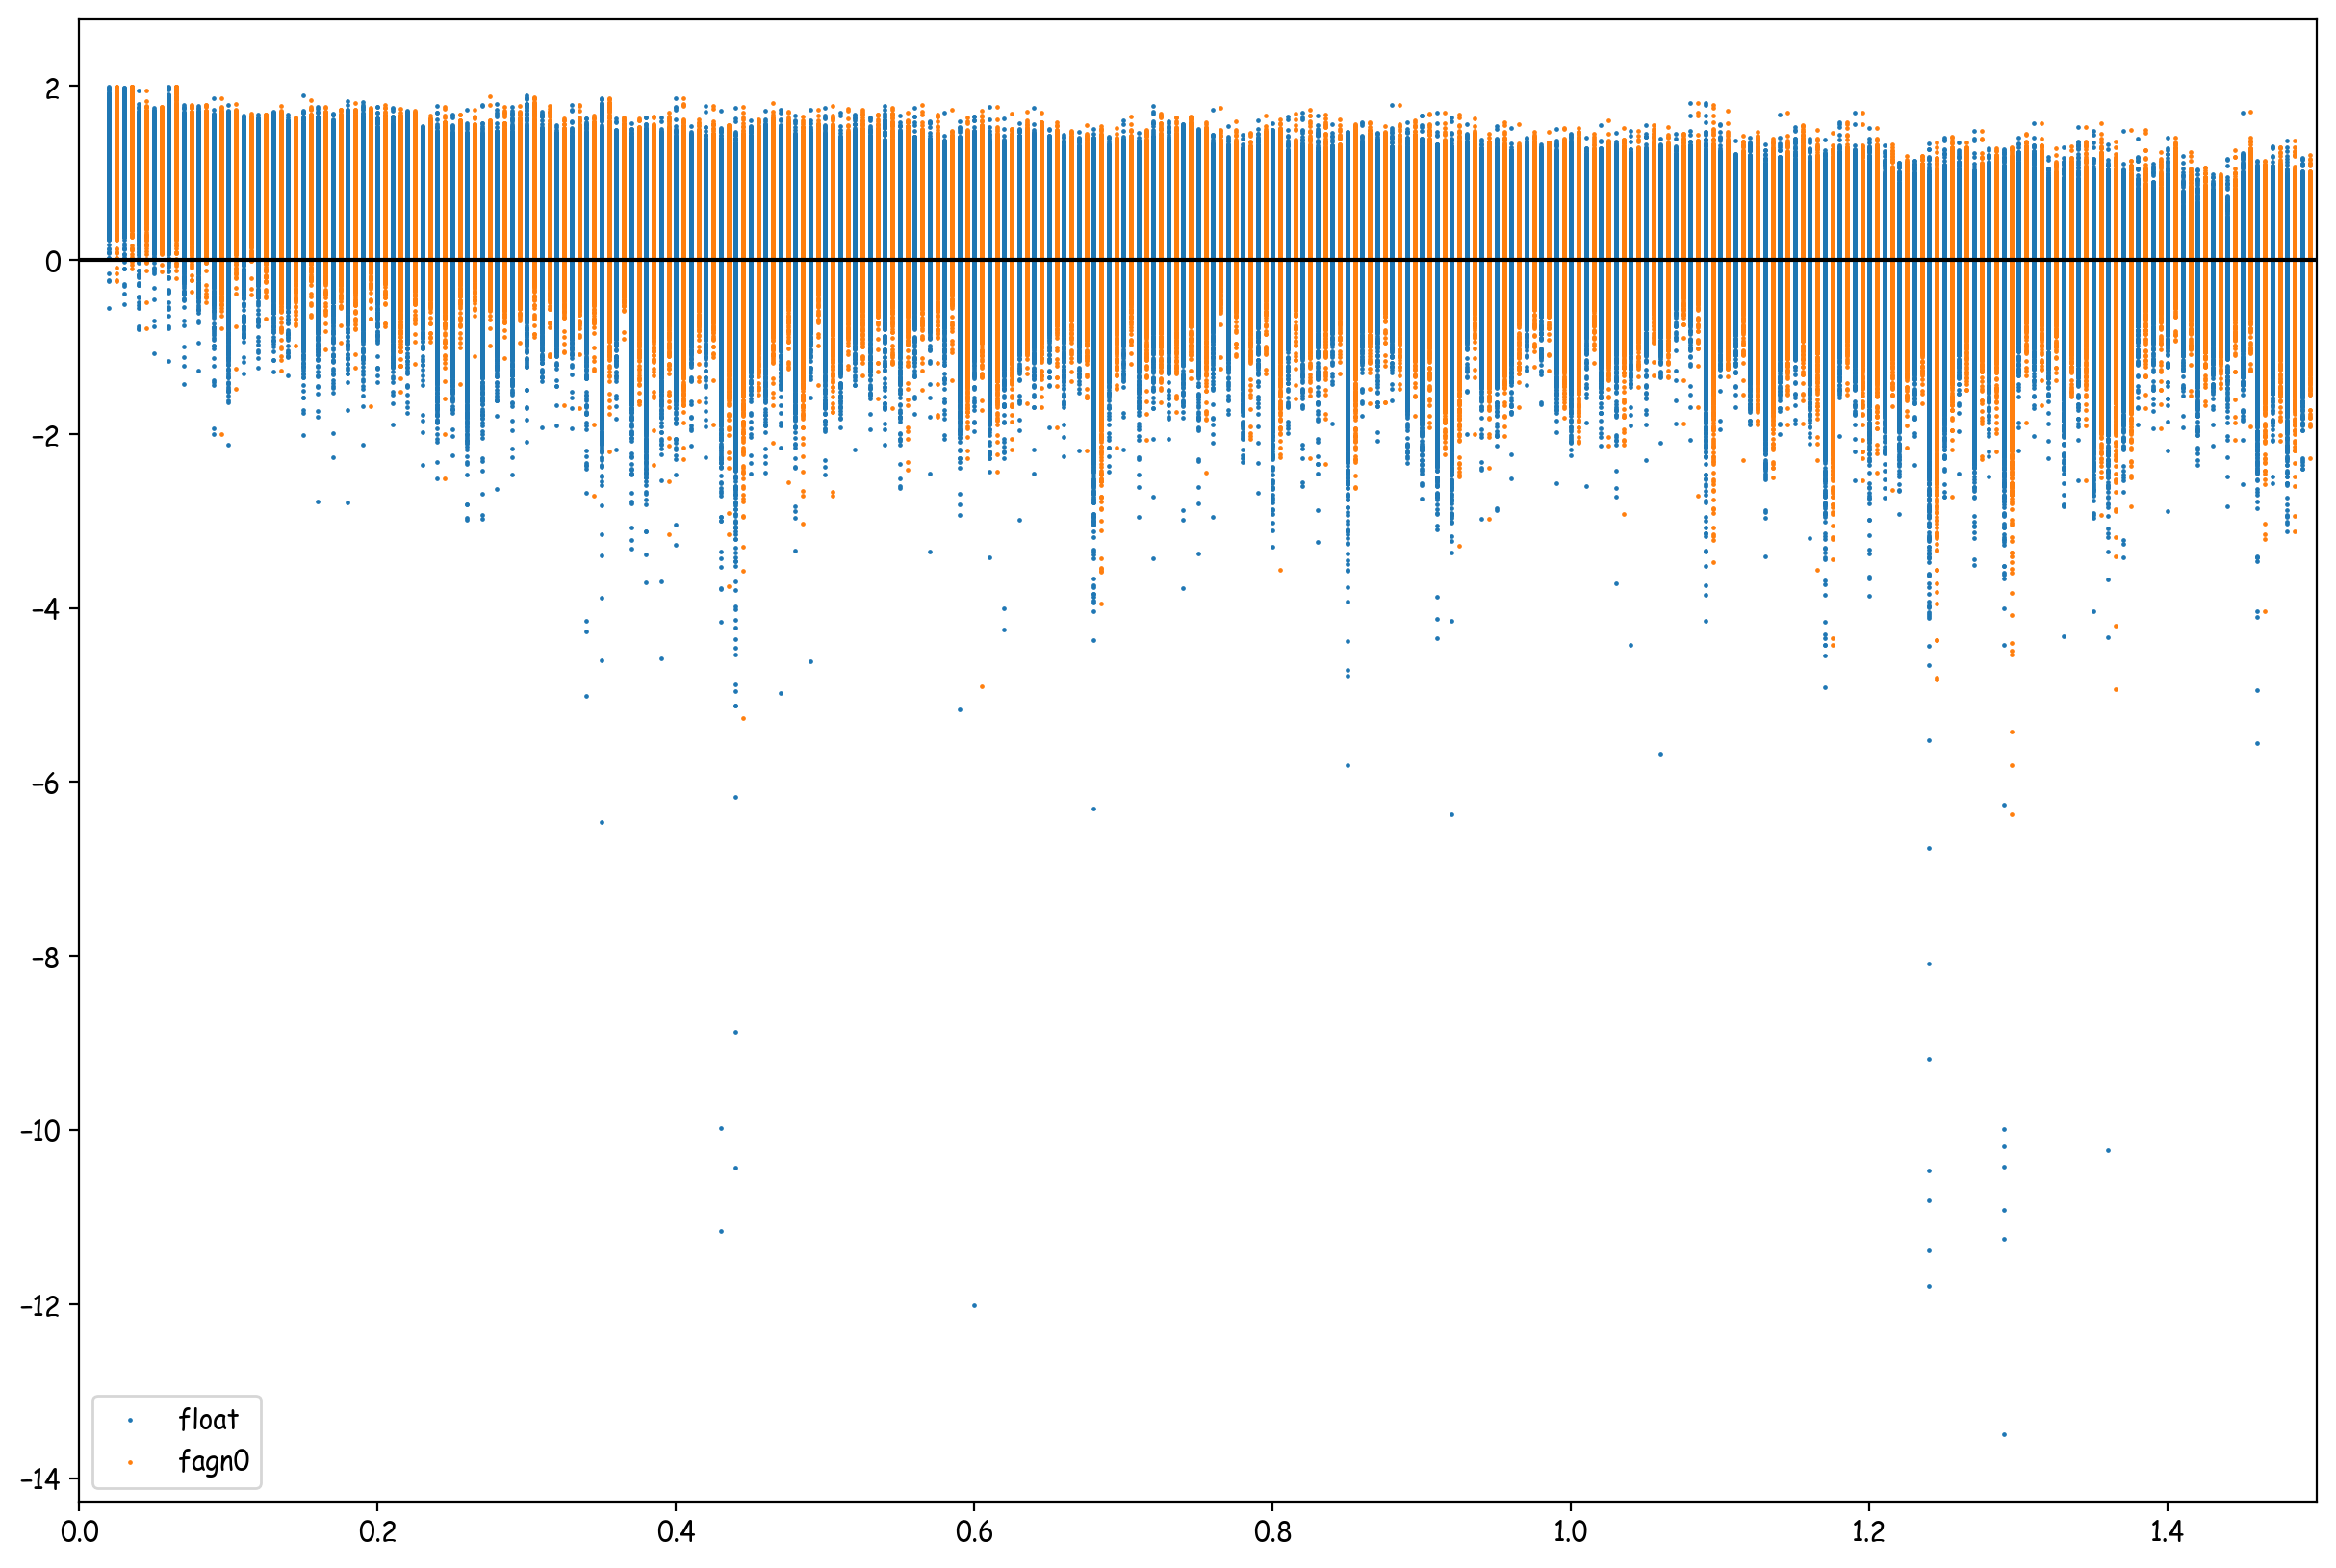

In [ ]:
fig = plt.figure(figsize=[15, 10])
plt.scatter(redshift, np.log10(float_chi2), marker='.', s=2, label='float')
plt.scatter(redshift+0.005, np.log10(fagn0_chi2), marker='.', s=2, label='fagn0')

plt.xlim(0, 1.5)
plt.hlines(y=0, xmin=0, xmax=1.5, colors='k')
plt.legend()

plt.show()

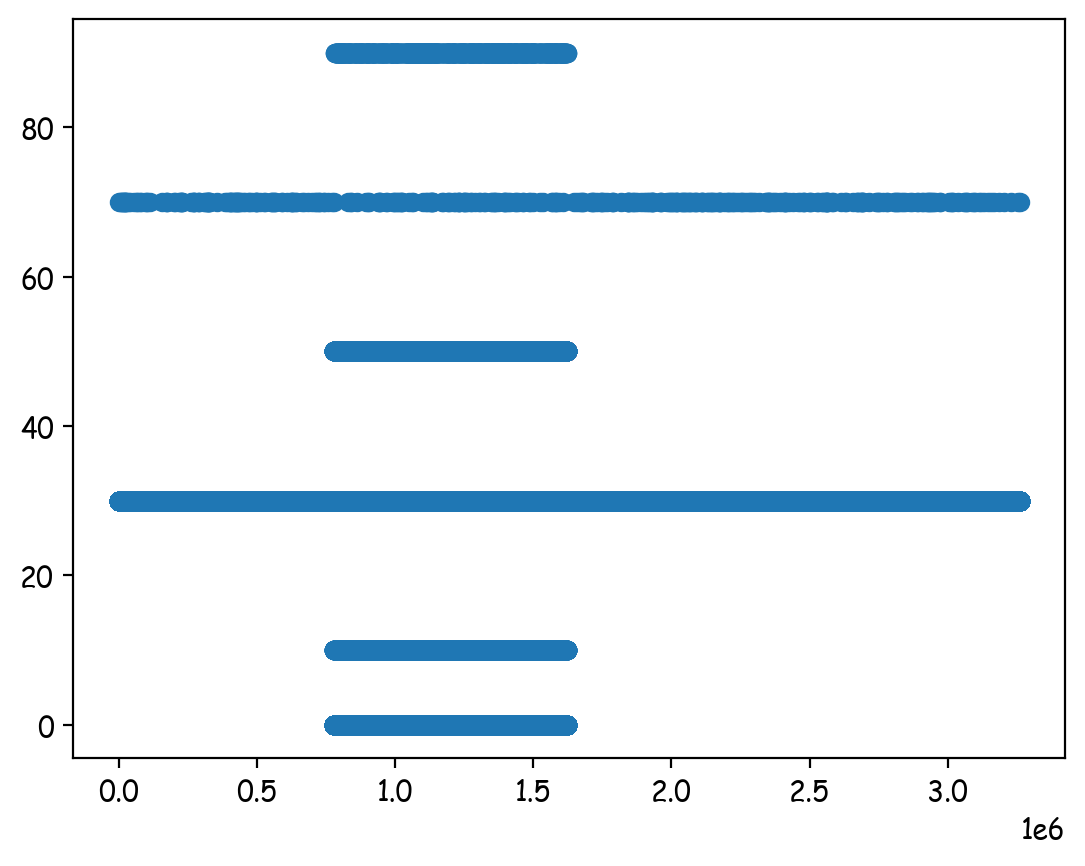

In [ ]:
plt.scatter(range(len(cigale_float['best.agn.i'])), cigale_float['best.agn.i'])

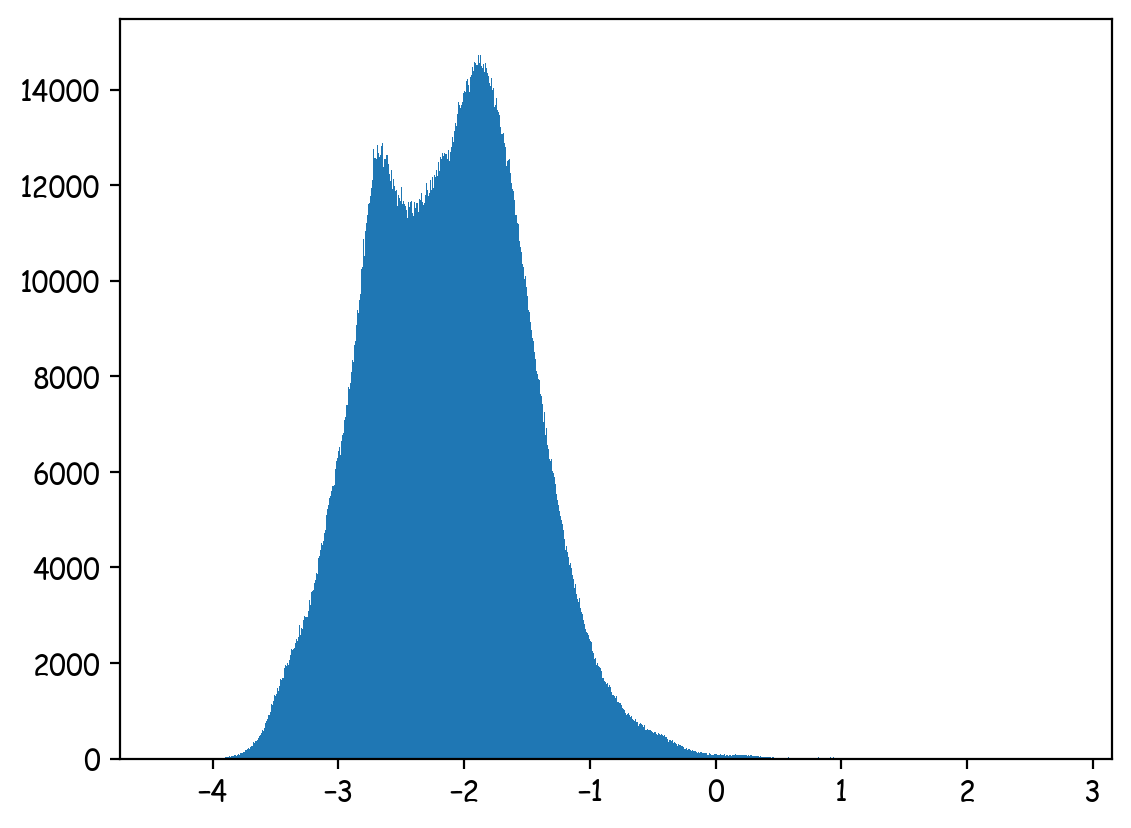

In [ ]:
_=plt.hist(np.log10(cigale_float['best.i_prime']), bins=1000)

$23.9 ; \mathrm{mag}$ $\mathrm{\left( \mathrm{AB} \right)}$

In [ ]:
a=1
dir(a)
a.__name__

AttributeError: 'int' object has no attribute '__name__'

In [ ]:
# reading needs 12mins
wise25 = ascii.read(os.path.join(data_dir, 'wise-allwise-cat-part25'), format='no_header',  delimiter='|', guess=False, fast_reader={'chunk_size': 1000*1000000})

In [ ]:
wise25[0]

<Row index=0>
        col1            col2       col3      col4    col5    col6      col7       col8      col9       col10     col11    col12          col13               col14             col15     col16  col17   col18   col19    col20     col21   col22   col23     col24     col25   col26   col27     col28     col29   col30   col31    col32      col33    col34 col35  col36   col37   col38   col39  col40    col41      col42     col43   col44   col45  col46 col47 col48 col49   col50       col51       col52      col53      col54    col55 col56 col57 col58 col59 col60 col61 col62 col63 col64 col65 col66 col67 col68 col69 col70  col71   col72   col73   col74  col75 col76 col77 col78 col79 col80 col81 col82        col83        col84   col85      col86     col87   col88   col89    col90      col91     col92   col93   col94    col95      col96     col97    col98   col99    col100     col101    col102  col103  col104  col105  col106 col107  col108  col109  col110 col111  col112  col113  col114 col115  col116  col117  col118 col119  col120  col121  col122 col123  col124  col125 col126  col127  col128 col129  col130  col131 col132  col133  col134 col135  col136  col137 col138  col139  col140 col141  col142  col143 col144  col145  col146 col147  col148  col149 col150  col151  col152 col153  col154  col155 col156  col157  col158 col159  col160  col161 col162  col163  col164 col165  col166  col167 col168  col169  col170 col171  col172  col173 col174  col175  col176 col177  col178  col179 col180  col181  col182 col183  col184  col185 col186  col187  col188 col189  col190  col191 col192  col193  col194 col195  col196  col197 col198  col199  col200 col201  col202  col203 col204  col205  col206 col207  col208  col209 col210  col211  col212 col213  col214  col215 col216  col217  col218  col219  col220 col221  col222     col223         col224         col225      col226  col227  col228  col229 col230  col231     col232         col233         col234      col235  col236  col237  col238 col239  col240     col241         col242         col243      col244  col245  col246  col247 col248  col249     col250         col251         col252     col253 col254 col255 col256 col257 col258  col259  col260  col261  col262  col263  col264 col265  col266  col267  col268  col269  col270 col271  col272  col273  col274  col275  col276 col277  col278  col279  col280  col281  col282 col283   col284   col285  col286 col287  col288  col289  col290  col291  col292  col293       col294             col295             col296         col297      col298    col299
       str19          float64    float64   float64 float64 float64   float64    float64   float64     float64   float64  float64         int64               str20             str13     int64 float64 float64 float64  float64   float64 float64 float64   float64   float64 float64 float64   float64   float64 float64 float64  float64    float64   int64 int64 float64 float64 float64 float64 int64   float64    float64   float64 float64 float64 int64 int64 int64 int64  float64     float64     float64    float64    float64    str5  str4  str1 int64  str4  str4 int64 int64 int64 int64 int64 int64 int64 int64 int64 int64 float64 float64 float64 float64 int64  str3 int64  str4 int64  str4 int64  str4        int64        int64  float64    float64   float64 float64 float64  float64    float64   float64 float64 float64  float64    float64   float64  float64 float64  float64    float64   float64 float64 float64 float64 float64 int64  float64 float64 float64 int64  float64 float64 float64 int64  float64 float64 float64 int64  float64 float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 int64  float64 float64 in

In [ ]:
import matplotlib.patches as patches
dir(patches)

['Annulus',
 'Arc',
 'Arrow',
 'ArrowStyle',
 'BoxStyle',
 'CapStyle',
 'Circle',
 'CirclePolygon',
 'ConnectionPatch',
 'ConnectionStyle',
 'Ellipse',
 'FancyArrow',
 'FancyArrowPatch',
 'FancyBboxPatch',
 'JoinStyle',
 'NonIntersectingPathException',
 'Number',
 'Patch',
 'Path',
 'PathPatch',
 'Polygon',
 'Rectangle',
 'RegularPolygon',
 'Shadow',
 'StepPatch',
 'Wedge',
 '_Style',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_api',
 '_docstring',
 '_point_along_a_line',
 '_register_style',
 'artist',
 'bbox_artist',
 'cbook',
 'colors',
 'draw_bbox',
 'functools',
 'get_cos_sin',
 'get_intersection',
 'get_parallels',
 'inside_circle',
 'inspect',
 'make_wedged_bezier2',
 'math',
 'mhatch',
 'mlines',
 'mpl',
 'namedtuple',
 'np',
 'split_bezier_intersecting_with_closedpath',
 'split_path_inout',
 'textwrap',
 'transforms']

In [ ]:
ligo.skymap.plot.make_rect_poly(100, 100, 0, 0, subdivisions=10)

/home/chisen/anaconda3/envs/py39-wsl2/lib/python3.9/site-packages/ligo/skymap/plot/poly.py:175: RuntimeWarning: invalid value encountered in sqrt
  v = np.hstack((v, np.sqrt(1. - np.expand_dims(np.square(v).sum(1), 1))))


array([[       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [3.14159265, 0.17453293],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [4.71238898, 0.17453293],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [0.        , 0.17453293],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [  

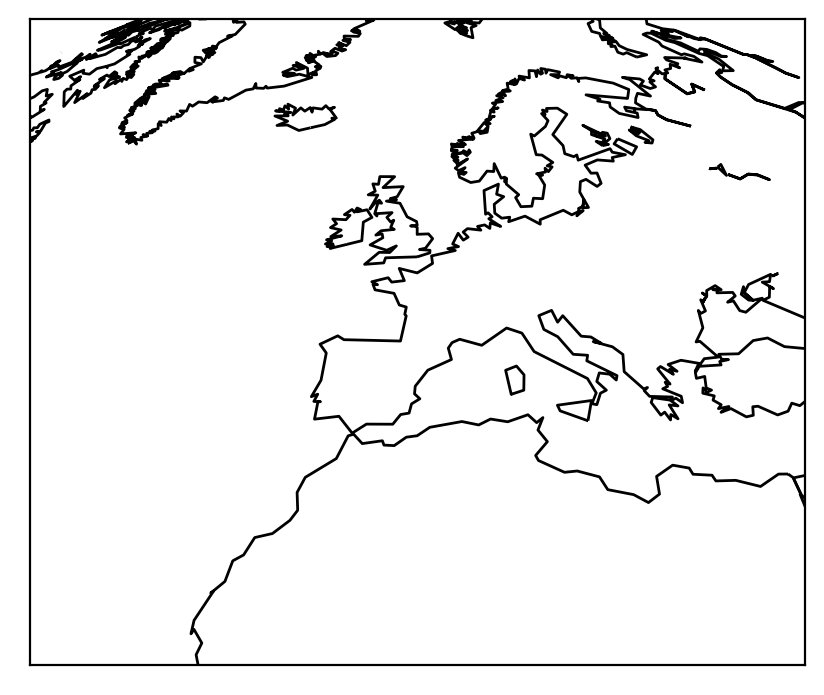

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5,5))

m = Basemap(projection = 'ortho', lon_0 = 0, lat_0 = 10,
            llcrnrx=-3000000, llcrnry=1000000, urcrnrx=3000000, urcrnry=6000000, 
            resolution = 'c')

m.drawcoastlines(linewidth = 1)
# m.drawcountries()

plt.show()

TypeError: Changing axes limits of a geographic projection is not supported.  Please consider using Cartopy.

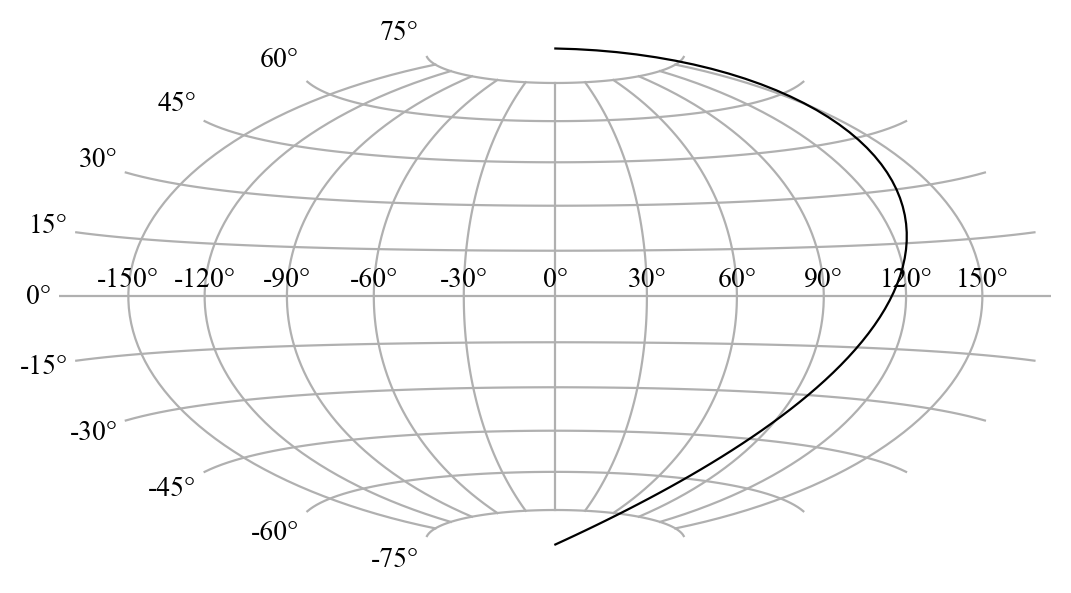

In [ ]:
import matplotlib
from matplotlib.axes import Axes
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from matplotlib.path import Path
from matplotlib.ticker import NullLocator, Formatter, FixedLocator
from matplotlib.transforms import Affine2D, BboxTransformTo, Transform
from matplotlib.projections import register_projection
import matplotlib.spines as mspines
import matplotlib.axis as maxis
import numpy as np
from matplotlib.path import Path

rcParams = matplotlib.rcParams

# This example projection class is rather long, but it is designed to
# illustrate many features, not all of which will be used every time.
# It is also common to factor out a lot of these methods into common
# code used by a number of projections with similar characteristics
# (see geo.py).


class GeoAxes(Axes):
    """
    An abstract base class for geographic projections
    """
    class ThetaFormatter(Formatter):
        """
        Used to format the theta tick labels.  Converts the native
        unit of radians into degrees and adds a degree symbol.
        """
        def __init__(self, round_to=1.0):
            self._round_to = round_to

        def __call__(self, x, pos=None):
            degrees = round(np.rad2deg(x) / self._round_to) * self._round_to
            return f"{degrees:0.0f}\N{DEGREE SIGN}"

    RESOLUTION = 75

    def _init_axis(self):
        self.xaxis = maxis.XAxis(self)
        self.yaxis = maxis.YAxis(self)
        # Do not register xaxis or yaxis with spines -- as done in
        # Axes._init_axis() -- until GeoAxes.xaxis.clear() works.
        # self.spines['geo'].register_axis(self.yaxis)

    def clear(self):
        # docstring inherited
        super().clear()

        self.set_longitude_grid(30)
        self.set_latitude_grid(15)
        self.set_longitude_grid_ends(75)
        self.xaxis.set_minor_locator(NullLocator())
        self.yaxis.set_minor_locator(NullLocator())
        self.xaxis.set_ticks_position('none')
        self.yaxis.set_ticks_position('none')
        self.yaxis.set_tick_params(label1On=True)
        # Why do we need to turn on yaxis tick labels, but
        # xaxis tick labels are already on?

        self.grid(rcParams['axes.grid'])

        Axes.set_xlim(self, -np.pi, np.pi)
        Axes.set_ylim(self, -np.pi / 2.0, np.pi / 2.0)

    def _set_lim_and_transforms(self):
        # A (possibly non-linear) projection on the (already scaled) data

        # There are three important coordinate spaces going on here:
        #
        # 1. Data space: The space of the data itself
        #
        # 2. Axes space: The unit rectangle (0, 0) to (1, 1)
        #    covering the entire plot area.
        #
        # 3. Display space: The coordinates of the resulting image,
        #    often in pixels or dpi/inch.

        # This function makes heavy use of the Transform classes in
        # ``lib/matplotlib/transforms.py.`` For more information, see
        # the inline documentation there.

        # The goal of the first two transformations is to get from the
        # data space (in this case longitude and latitude) to axes
        # space.  It is separated into a non-affine and affine part so
        # that the non-affine part does not have to be recomputed when
        # a simple affine change to the figure has been made (such as
        # resizing the window or changing the dpi).

        # 1) The core transformation from data space into
        # rectilinear space defined in the HammerTransform class.
        self.transProjection = self._get_core_transform(self.RESOLUTION)

        # 2) The above has an output range that is not in the unit
        # rectangle, so scale and translate it so it fits correctly
        # within the axes.  The peculiar calculations of xscale and
        # yscale are specific to an Aitoff-Hammer projection, so don't
        # worry about them too much.
        self.transAffine = self._get_affine_transform()

        # 3) This is the transformation from axes space to display
        # space.
        self.transAxes = BboxTransformTo(self.bbox)

        # Now put these 3 transforms together -- from data all the way
        # to display coordinates.  Using the '+' operator, these
        # transforms will be applied "in order".  The transforms are
        # automatically simplified, if possible, by the underlying
        # transformation framework.
        self.transData = \
            self.transProjection + \
            self.transAffine + \
            self.transAxes

        # The main data transformation is set up.  Now deal with
        # gridlines and tick labels.

        # Longitude gridlines and ticklabels.  The input to these
        # transforms are in display space in x and axes space in y.
        # Therefore, the input values will be in range (-xmin, 0),
        # (xmax, 1).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the equator.
        self._xaxis_pretransform = \
            Affine2D() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)
        self._xaxis_transform = \
            self._xaxis_pretransform + \
            self.transData
        self._xaxis_text1_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, 4.0)
        self._xaxis_text2_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, -4.0)

        # Now set up the transforms for the latitude ticks.  The input to
        # these transforms are in axes space in x and display space in
        # y.  Therefore, the input values will be in range (0, -ymin),
        # (1, ymax).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the edge of the axes ellipse.
        yaxis_stretch = Affine2D().scale(np.pi*2, 1).translate(-np.pi, 0)
        yaxis_space = Affine2D().scale(1.0, 1.1)
        self._yaxis_transform = \
            yaxis_stretch + \
            self.transData
        yaxis_text_base = \
            yaxis_stretch + \
            self.transProjection + \
            (yaxis_space +
             self.transAffine +
             self.transAxes)
        self._yaxis_text1_transform = \
            yaxis_text_base + \
            Affine2D().translate(-8.0, 0.0)
        self._yaxis_text2_transform = \
            yaxis_text_base + \
            Affine2D().translate(8.0, 0.0)

    def _get_affine_transform(self):
        transform = self._get_core_transform(1)
        xscale, _ = transform.transform((np.pi, 0))
        _, yscale = transform.transform((0, np.pi/2))
        return Affine2D() \
            .scale(0.5 / xscale, 0.5 / yscale) \
            .translate(0.5, 0.5)

    def get_xaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        if which not in ['tick1', 'tick2', 'grid']:
            raise ValueError(
                "'which' must be one of 'tick1', 'tick2', or 'grid'")
        return self._xaxis_transform

    def get_xaxis_text1_transform(self, pad):
        return self._xaxis_text1_transform, 'bottom', 'center'

    def get_xaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._xaxis_text2_transform, 'top', 'center'

    def get_yaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        y-axis grid and ticks.
        """
        if which not in ['tick1', 'tick2', 'grid']:
            raise ValueError(
                "'which' must be one of 'tick1', 'tick2', or 'grid'")
        return self._yaxis_transform

    def get_yaxis_text1_transform(self, pad):
        """
        Override this method to provide a transformation for the
        y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text1_transform, 'center', 'right'

    def get_yaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text2_transform, 'center', 'left'

    def _gen_axes_patch(self):
        """
        Override this method to define the shape that is used for the
        background of the plot.  It should be a subclass of Patch.

        In this case, it is a Circle (that may be warped by the axes
        transform into an ellipse).  Any data and gridlines will be
        clipped to this shape.
        """
        return Rectangle((0, 0), 1, 1)

    def _gen_axes_spines(self):
        return {'geo': mspines.Spine(self, 'left', Path([[1, 2], [3, 4]]))}

    def set_yscale(self, *args, **kwargs):
        if args[0] != 'linear':
            raise NotImplementedError

    # Prevent the user from applying scales to one or both of the
    # axes.  In this particular case, scaling the axes wouldn't make
    # sense, so we don't allow it.
    set_xscale = set_yscale

    # Prevent the user from changing the axes limits.  In our case, we
    # want to display the whole sphere all the time, so we override
    # set_xlim and set_ylim to ignore any input.  This also applies to
    # interactive panning and zooming in the GUI interfaces.
    def set_xlim(self, *args, **kwargs):
        raise TypeError("Changing axes limits of a geographic projection is "
                        "not supported.  Please consider using Cartopy.")

    set_ylim = set_xlim

    def format_coord(self, lon, lat):
        """
        Override this method to change how the values are displayed in
        the status bar.

        In this case, we want them to be displayed in degrees N/S/E/W.
        """
        lon, lat = np.rad2deg([lon, lat])
        ns = 'N' if lat >= 0.0 else 'S'
        ew = 'E' if lon >= 0.0 else 'W'
        return ('%f\N{DEGREE SIGN}%s, %f\N{DEGREE SIGN}%s'
                % (abs(lat), ns, abs(lon), ew))

    def set_longitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface to set the
        ticking than set_xticks would.
        """
        # Skip -180 and 180, which are the fixed limits.
        grid = np.arange(-180 + degrees, 180, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_latitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface than
        set_yticks would.
        """
        # Skip -90 and 90, which are the fixed limits.
        grid = np.arange(-90 + degrees, 90, degrees)
        self.yaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.yaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_longitude_grid_ends(self, degrees):
        """
        Set the latitude(s) at which to stop drawing the longitude grids.

        Often, in geographic projections, you wouldn't want to draw
        longitude gridlines near the poles.  This allows the user to
        specify the degree at which to stop drawing longitude grids.

        This is an example method that is specific to this projection
        class -- it provides an interface to something that has no
        analogy in the base Axes class.
        """
        self._longitude_cap = np.deg2rad(degrees)
        self._xaxis_pretransform \
            .clear() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)

    def get_data_ratio(self):
        """
        Return the aspect ratio of the data itself.

        This method should be overridden by any Axes that have a
        fixed data ratio.
        """
        return 1.0

    # Interactive panning and zooming is not supported with this projection,
    # so we override all of the following methods to disable it.
    def can_zoom(self):
        """
        Return whether this Axes supports the zoom box button functionality.

        This Axes object does not support interactive zoom box.
        """
        return False

    def can_pan(self):
        """
        Return whether this Axes supports the pan/zoom button functionality.

        This Axes object does not support interactive pan/zoom.
        """
        return False

    def start_pan(self, x, y, button):
        pass

    def end_pan(self):
        pass

    def drag_pan(self, button, key, x, y):
        pass


class HammerAxes(GeoAxes):
    """
    A custom class for the Aitoff-Hammer projection, an equal-area map
    projection.

    https://en.wikipedia.org/wiki/Hammer_projection
    """

    # The projection must specify a name. This will be used by the
    # user to select the projection,
    # i.e. ``subplot(projection='custom_hammer')``.
    name = 'custom_hammer'

    class HammerTransform(Transform):
        """The base Hammer transform."""
        input_dims = output_dims = 2

        def __init__(self, resolution):
            """
            Create a new Hammer transform.  Resolution is the number of steps
            to interpolate between each input line segment to approximate its
            path in curved Hammer space.
            """
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, ll):
            longitude, latitude = ll.T

            # Pre-compute some values
            half_long = longitude / 2
            cos_latitude = np.cos(latitude)
            sqrt2 = np.sqrt(2)

            alpha = np.sqrt(1 + cos_latitude * np.cos(half_long))
            x = (2 * sqrt2) * (cos_latitude * np.sin(half_long)) / alpha
            y = (sqrt2 * np.sin(latitude)) / alpha
            return np.column_stack([x, y])

        def transform_path_non_affine(self, path):
            # vertices = path.vertices
            ipath = path.interpolated(self._resolution)
            return Path(self.transform(ipath.vertices), ipath.codes)

        def inverted(self):
            return HammerAxes.InvertedHammerTransform(self._resolution)

    class InvertedHammerTransform(Transform):
        input_dims = output_dims = 2

        def __init__(self, resolution):
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, xy):
            x, y = xy.T
            z = np.sqrt(1 - (x / 4) ** 2 - (y / 2) ** 2)
            longitude = 2 * np.arctan((z * x) / (2 * (2 * z ** 2 - 1)))
            latitude = np.arcsin(y*z)
            return np.column_stack([longitude, latitude])

        def inverted(self):
            return HammerAxes.HammerTransform(self._resolution)

    def __init__(self, *args, **kwargs):
        self._longitude_cap = np.pi / 2.0
        super().__init__(*args, **kwargs)
        self.set_aspect(0.5, adjustable='box', anchor='C')
        self.clear()

    def _get_core_transform(self, resolution):
        return self.HammerTransform(resolution)


# Now register the projection with Matplotlib so the user can select it.
register_projection(HammerAxes)


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    # Now make a simple example using the custom projection.
    fig, ax = plt.subplots(subplot_kw={'projection': 'custom_hammer'})
    # ax.plot([-1, 1, 1], [-1, -1, 1], "o-")
    ax.grid()
    ax.set_xlim(0, 100)

    plt.show()

In [ ]:
import importlib 
importlib.reload(ligo.skymap.plot)
importlib.reload(ligo.skymap.plot.allsky)

<module 'ligo.skymap.plot.allsky' from '/home/chisen/anaconda3/envs/py39-wsl2/lib/python3.9/site-packages/ligo/skymap/plot/allsky.py'>

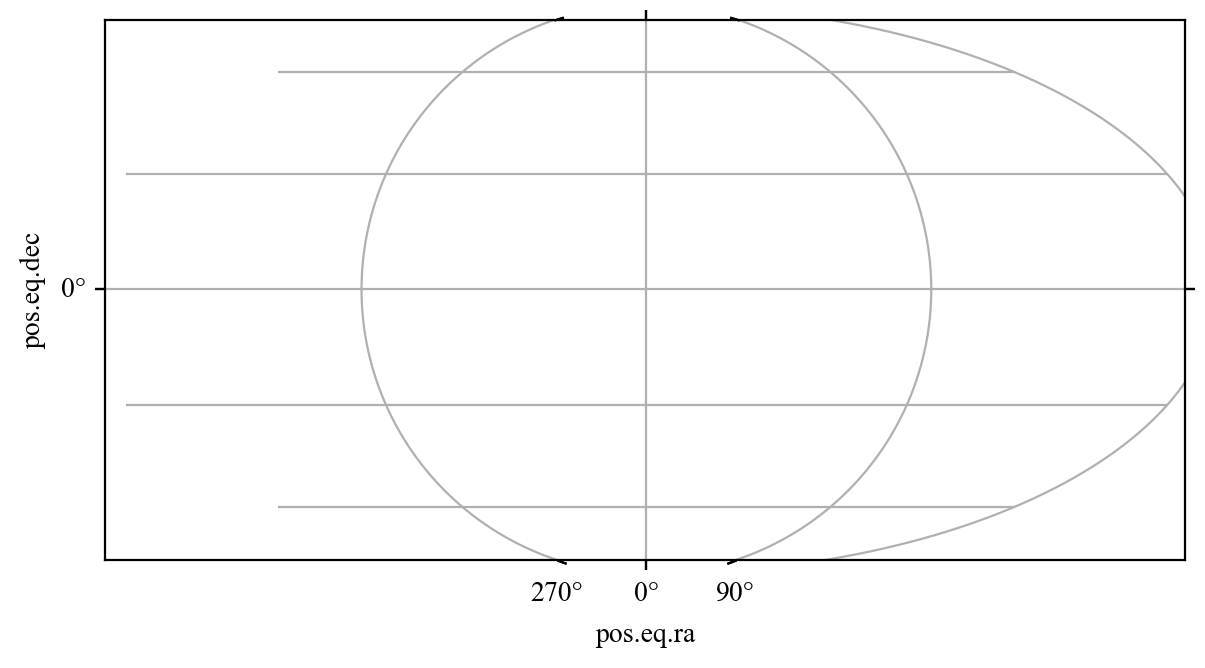

In [27]:
from ligo.skymap.plot.allsky import Astro, Degrees, Globe, WCSInsetConnectionPatch, WCSCircleInsetConnectionPatch, AutoScaledWCSAxes
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from matplotlib.projections import register_projection
from astropy.coordinates import SkyCoord, UnitSphericalRepresentation
from astropy.visualization.wcsaxes import SphericalCircle, WCSAxes

class AstroDegreesClip(AutoScaledWCSAxes): 
    
    name = 'astro degrees clip'
    
    '''Astro'''
    _crval1 = 180
    _xcoord = 'RA--'
    _ycoord = 'DEC-'
    _radesys = 'ICRS'

    def __init__(self, *args, center='0d 0d', width = '1 deg', height='1 deg', rotate=None,
                 **kwargs):
        
        '''Clip'''
        center = SkyCoord(
            center, representation_type=UnitSphericalRepresentation).icrs
        width = u.Quantity(width).to(u.deg).value
        height = u.Quantity(height).to(u.deg).value
        header = {
            'NAXIS': 2,
            'NAXIS1': 512*width,
            'NAXIS2': 512*height,
            'CRPIX1': 256.5*width,
            'CRPIX2': 256.5*height,
            'CRVAL1': center.ra.deg,
            'CRVAL2': center.dec.deg,
            'CDELT1': 0.003, # -width / 1024,
            'CDELT2': 0.003, # height / 1024,
            'CTYPE1': self._xcoord + '-MOL', # '-SIN',
            'CTYPE2': self._ycoord + '-MOL', # '-SIN',
            'RADESYS': self._radesys}
        if rotate is not None:
            header['LONPOLE'] = u.Quantity(rotate).to_value(u.deg)
        super().__init__(*args, header=header, **kwargs) # frame_class=EllipticalFrame
        
        '''Degrees'''
        self.coords[0].set_format_unit(u.degree)

register_projection(AstroDegreesClip)



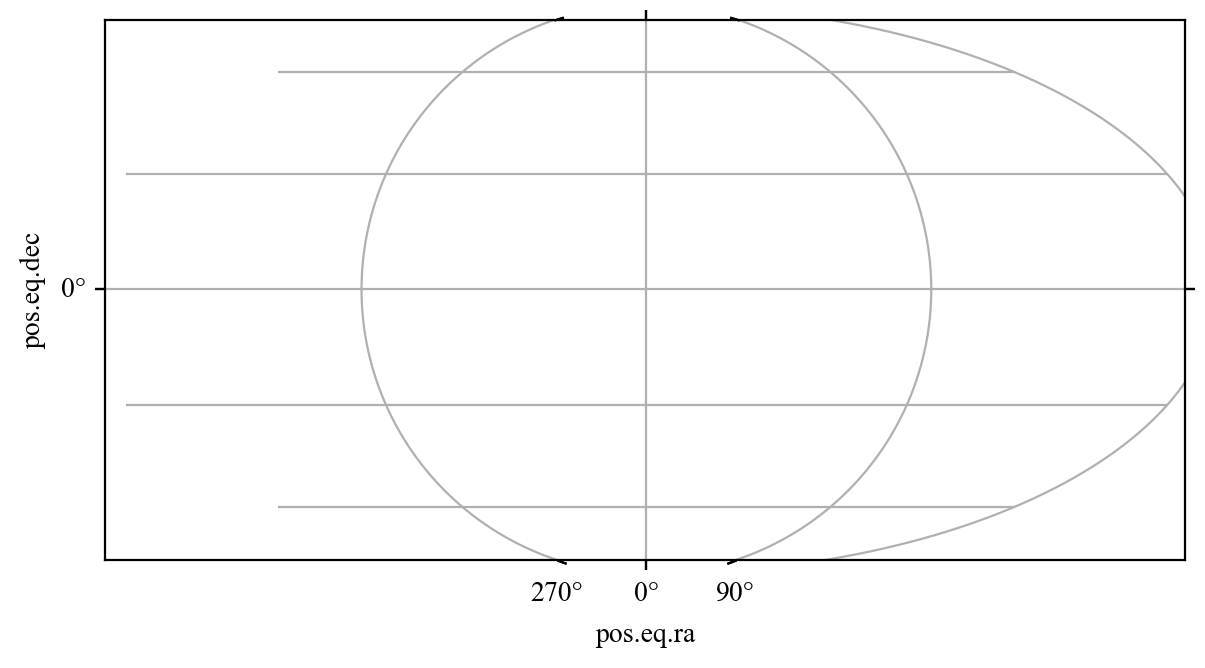

In [28]:
fig = plt.figure(figsize=[12, 8], dpi=100)
ax1 = plt.axes([0, 0.55, 0.45, 0.45], projection='astro degrees clip', center='0d 0d', width = '200 deg', height='100 deg')

ax1.grid()
# ax1.set_aspect(1)

plt.show()